# Improving Hospital Inpatient Discharge With Machine Learning Models
### MSc Data Science Project 
##### Monisha Jetly


## 1. Introduction
This notebook presents a comparative analysis on predicting Hospital Inpatient Discharge with a focus on analysing the financial impact due to prediction errors. The notebook aims to answer the following research question. 

### 1.1 Research Question
Which machine learning regression model provides better performance in predicting patient Lenght of Stay (LOS)? Which clinical and demographic factors are the most important determinants of LOS? What is the potential financial impact of errors in the predictions on the allocation of hospital resources?

### 1.2 Project Pipeline
1. Data Preparation - Processing data provided by The Statewide Planning and Research Cooperative System (SPARCS) from the New York State Department of Health.
2. Exploratory Data Analysis - Understanding the relationships and patterns of inpatients. 
3. Model Development - Finding the best performing machine learning algorithm to predict length of stay. The models used in this notebook are Random Forest, XGBoost and LightGBM.
4. Financial Impact - To quantify how prediction errors such as overprediction and underprediction can lead to significant financial savings for healthcare institutions.
5. Results and Recommendations - Actionable insights for healthcare institutions.

In [1]:
# Importing necessary libraries for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

In [2]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [3]:
# Loading the data set
df_2023 = pd.read_csv('data_2023.csv')

C:\Users\malaj\AppData\Local\Temp\ipykernel_22008\3276510456.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv('data_2023.csv')


## 2. Data Cleaning
This section focuses on cleaning the dataset by addressing issues like outliers, missing values, and inconsistent data to create a reliable dataset for further sections.

In [4]:
# Describing the shape (rows, columns) of the dataset
df_2023.shape

(2125754, 33)

In [5]:
# Describing the columns of the dataset
df_2023.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'CCSR Procedure Code',
       'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [6]:
# Replacing whitespaces with underscores to maintain consistency
df_2023.columns = df_2023.columns.str.replace(' ', '_')

In [7]:
# Renaming columns to represent the data better
df_2023.rename(columns={
        'Hospital_County': 'County',
        'Zip_Code_-_3_digits': 'Zip_Code',
        'Emergency_Department_Indicator': 'Is_Emergency_Department_Indicator',
        'CCSR_Diagnosis_Code': 'Diagnosis_Code',
        'CCSR_Diagnosis_Description': 'Diagnosis_Description',
        'CCSR_Procedure_Code': 'Procedure_Code',
        'CCSR_Procedure_Description': 'Procedure_Description',
        'Total_Costs':'Total_Cost',
        'Permanent_Facility_Id':'Facility_Id', 
        'Hospital_Service_Area':'Health_Service_Area'
    }, inplace=True)

In [8]:
# Converting the columns to lowercase to maintain consistency
df_2023.columns = df_2023.columns.str.lower()

In [9]:
df_2023.columns

Index(['health_service_area', 'county', 'operating_certificate_number',
       'facility_id', 'facility_name', 'age_group', 'zip_code', 'gender',
       'race', 'ethnicity', 'length_of_stay', 'type_of_admission',
       'patient_disposition', 'discharge_year', 'diagnosis_code',
       'diagnosis_description', 'procedure_code', 'procedure_description',
       'apr_drg_code', 'apr_drg_description', 'apr_mdc_code',
       'apr_mdc_description', 'apr_severity_of_illness_code',
       'apr_severity_of_illness_description', 'apr_risk_of_mortality',
       'apr_medical_surgical_description', 'payment_typology_1',
       'payment_typology_2', 'payment_typology_3', 'birth_weight',
       'is_emergency_department_indicator', 'total_charges', 'total_cost'],
      dtype='object')

In [10]:
# Replacing Missing values of Birthweight with Unknown
df_2023["birth_weight"] = df_2023["birth_weight"].replace("Unknown", np.nan)
# Converting Birth Weight to numerical data type
df_2023["birth_weight"] = pd.to_numeric(df_2023["birth_weight"], errors="coerce")
# Groups the Age Group column with Birth Weight 
#To show the distribution of Birth weights across different age groups
counts = df_2023.groupby("age_group")["birth_weight"].count()
print(counts)

age_group
0 to 17        203882
18 to 29            0
30 to 49            0
50 to 69            0
70 or Older         0
Name: birth_weight, dtype: int64


In [11]:
# Birth Weight is dropped as it only pertains to newborns and not adults.
# APR severity of illness description is dropped as the APR severity of illness code represent the same information.
# Existence of payment typology 1 exists therefore type 2 and 3 are irrelevant.
# Zip code is irrelevant in predicting length of stay.
# The dataset contains the year 2023 therefore the column is not needed.
cols_to_drop = ['apr_severity_of_illness_description','payment_typology_2', 'payment_typology_3',
                'birth_weight','zip_code','discharge_year']
df_2023 = df_2023.drop(columns=cols_to_drop)

In [12]:
# Creating a new copy of the dataset to proceed with data cleaning 
df_clean = df_2023.copy()
print("Converting numerical columns to proper data type")
numerical_cols = ['length_of_stay', 'total_charges', 'total_cost']
for col in numerical_cols:
    if col in df_clean.columns:
        # Converting numerical columns to numeric, forcing any errors to NaN
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        print(f"Converted {col} to numeric")

Converting numerical columns to proper data type
Converted length_of_stay to numeric
Converted total_charges to numeric
Converted total_cost to numeric


In [13]:
# Displaying Missing values
print("Handling missing values")
missing_values = df_clean.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Handling missing values
Missing values per column:
health_service_area                5333
county                             5333
operating_certificate_number       5333
facility_id                        5333
length_of_stay                     2290
procedure_code                   611024
procedure_description            611024
apr_risk_of_mortality               474
total_charges                   2124985
total_cost                      2109005
dtype: int64


In [14]:
# Handling missing values for numerical columns by using the median.
for col in numerical_cols:
    if col in df_clean.columns:
        # Checks if column has any non null values before calculating median
        if not df_clean[col].isnull().all():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"Filled missing {col} with median: {median_val}")
        else:
            # If all values are null, fills the missing value with 0
            df_clean[col] = df_clean[col].fillna(0)
            print(f"All values in {col} were missing, filled with 0")


Filled missing length_of_stay with median: 3.0
Filled missing total_charges with median: 772.77
Filled missing total_cost with median: 813.72


In [15]:
# Handling missing values for categorical columns
categorical_cols = ['gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition']
for col in categorical_cols:
    if col in df_clean.columns:
        # Fills non null values with Unknown
        df_clean[col] = df_clean[col].fillna('Unknown')

In [16]:
# Fills missing values with 'N'
if 'is_emergency_department_indicator' in df_clean.columns:
    df_clean['is_emergency_department_indicator'] = df_clean['is_emergency_department_indicator'].fillna('N')
#Displays the number of expired patients
if 'patient_disposition' in df_clean.columns:
    expired_count = (df_clean['patient_disposition'] == 'Expired').sum()
    print(f"Found {expired_count} expired records")
    
    # Keeping only non expired records for length of stay prediction
    # Therefore, removing expired patients.
    original_count = len(df_clean)
    df_clean = df_clean[df_clean['patient_disposition'] != 'Expired'].copy()
    removed_count = original_count - len(df_clean)
    print(f"Removed {removed_count} expired records")

Found 53845 expired records
Removed 53845 expired records


In [17]:
# Cleaning and preprocess APR (All Patient Refined) columns
print("Cleaning APR Clinical Columns")

if 'apr_severity_of_illness_code' in df_clean.columns:
    print("Cleaning apr_severity_of_illness_code...")
    
    # Displays current values and missing data
    print(f"Original values: {df_clean['apr_severity_of_illness_code'].unique()}")
    print(f"Missing values: {df_clean['apr_severity_of_illness_code'].isnull().sum()}")
    
    # Handling missing values by creating a 'Missing' category
    df_clean['apr_severity_of_illness_code'] = df_clean['apr_severity_of_illness_code'].fillna('Missing')
    
    # Converting to string and strip whitespace
    df_clean['apr_severity_of_illness_code'] = df_clean['apr_severity_of_illness_code'].astype(str).str.strip()
    
    # Mapping to standardized categories
    severity_mapping = {
        '1': 'Minor',
        '2': 'Moderate', 
        '3': 'Major',
        '4': 'Extreme',
        'Missing': 'Missing',
        'nan': 'Missing',
        'None': 'Missing',
        'NULL': 'Missing'
    }
    df_clean['apr_severity_clean'] = df_clean['apr_severity_of_illness_code'].map(severity_mapping)
    
    # For any unmapped values, use the original value
    unmapped = df_clean[df_clean['apr_severity_clean'].isnull()]
    if not unmapped.empty:
        print(f"Unmapped severity values: {unmapped['apr_severity_of_illness_code'].unique()}")
        df_clean['apr_severity_clean'] = df_clean['apr_severity_clean'].fillna('Other')
    
    print("Severity of Illness Distribution:")
    print(df_clean['apr_severity_clean'].value_counts())

Cleaning APR Clinical Columns
Cleaning apr_severity_of_illness_code...
Original values: [2 4 3 1 0]
Missing values: 0
Unmapped severity values: ['0']
Severity of Illness Distribution:
apr_severity_clean
Moderate    782204
Minor       627144
Major       493243
Extreme     168864
Other          454
Name: count, dtype: int64


In [18]:
# Cleaning apr_risk_of_mortality
if 'apr_risk_of_mortality' in df_clean.columns:
    print("\nCleaning apr_risk_of_mortality...")
    
    # Check current values and missing data
    print(f"Original values: {df_clean['apr_risk_of_mortality'].unique()}")
    print(f"Missing values: {df_clean['apr_risk_of_mortality'].isnull().sum()}")
    
    # Handle missing values
    df_clean['apr_risk_of_mortality'] = df_clean['apr_risk_of_mortality'].fillna('Missing')
    
    # Convert to string and strip whitespace
    df_clean['apr_mortality_risk_clean'] = df_clean['apr_risk_of_mortality'].astype(str).str.strip()
    
    print("Risk of Mortality Distribution:")
    print(df_clean['apr_mortality_risk_clean'].value_counts())


Cleaning apr_risk_of_mortality...
Original values: ['Moderate' 'Minor' 'Extreme' 'Major' nan]
Missing values: 454
Risk of Mortality Distribution:
apr_mortality_risk_clean
Minor       1072468
Moderate     452674
Major        388610
Extreme      157703
Missing         454
Name: count, dtype: int64


In [19]:
# Encoding for machine learning
if 'apr_severity_clean' in df_clean.columns:
    # Ordered encoding (0-4 for severity levels)
    severity_order = {'Minor': 1, 'Moderate': 2, 'Major': 3, 'Extreme': 4, 'Missing': 0, 'Other': 0}
    df_clean['apr_severity_encoded'] = df_clean['apr_severity_clean'].map(severity_order)
    
if 'apr_mortality_risk_clean' in df_clean.columns:
    # Ordered encoding (0-4 for risk levels)
    mortality_order = {'Minor': 1, 'Moderate': 2, 'Major': 3, 'Extreme': 4, 'Missing': 0, 'Other': 0}
    df_clean['apr_mortality_encoded'] = df_clean['apr_mortality_risk_clean'].map(mortality_order)

# Creating features
if all(col in df_clean.columns for col in ['apr_severity_encoded', 'apr_mortality_encoded']):
    # Creating a combined risk score of severity and mortality
    df_clean['apr_combined_risk'] = df_clean['apr_severity_encoded'] * df_clean['apr_mortality_encoded']
    
    # Creating a is high risk flag
    df_clean['is_high_risk'] = ((df_clean['apr_severity_encoded'] >= 3) | 
                               (df_clean['apr_mortality_encoded'] >= 3)).astype(int)
    
    print(f"\nHigh-risk patients (severity or mortality ≥ 3): {df_clean['is_high_risk'].sum()}")


High-risk patients (severity or mortality ≥ 3): 741265


In [20]:
# APR final distributions
print("Final APR Column Distributions:")
# Uses 'normalize=True' to show percentages rather than raw counts, making distributions easier to interpret.
if 'apr_severity_clean' in df_clean.columns:
    print("\nAPR Severity of Illness:")
    print(df_clean['apr_severity_clean'].value_counts(normalize=True) * 100)
    
if 'apr_mortality_risk_clean' in df_clean.columns:
    print("\nAPR Risk of Mortality:")
    print(df_clean['apr_mortality_risk_clean'].value_counts(normalize=True) * 100)

Final APR Column Distributions:

APR Severity of Illness:
apr_severity_clean
Moderate    37.752816
Minor       30.268897
Major       23.806210
Extreme      8.150165
Other        0.021912
Name: proportion, dtype: float64

APR Risk of Mortality:
apr_mortality_risk_clean
Minor       51.762312
Moderate    21.848160
Major       18.756133
Extreme      7.611483
Missing      0.021912
Name: proportion, dtype: float64


In [21]:
# Displaying relationship Between severity and length of stay
if all(col in df_clean.columns for col in ['apr_severity_clean', 'length_of_stay']):
    print("\n Average Length of Stay by Severity:")
    los_by_severity = df_clean.groupby('apr_severity_clean')['length_of_stay'].mean()
    print(los_by_severity.round(1))

# Cleaning values in length_of_stay
if 'length_of_stay' in df_clean.columns:
    # Replacing any remaining string values
    df_clean['length_of_stay'] = df_clean['length_of_stay'].replace('120 +', 120)
    # Converting to numeric again to ensure consistency
    df_clean['length_of_stay'] = pd.to_numeric(df_clean['length_of_stay'], errors='coerce')
    # Filling any new NaN values created by conversion
    if df_clean['length_of_stay'].isnull().any():
        median_los = df_clean['length_of_stay'].median()
        df_clean['length_of_stay'] = df_clean['length_of_stay'].fillna(median_los)


 Average Length of Stay by Severity:
apr_severity_clean
Extreme     13.7
Major        7.1
Minor        3.0
Moderate     4.8
Other        3.1
Name: length_of_stay, dtype: float64


In [22]:
# Handling Outliers 
for col in ['total_charges', 'total_cost','length_of_stay']:
    if col in df_clean.columns and df_clean[col].dtype in ['int64', 'float64','int64']:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 3 * IQR
        # Count of how many values exceed the upper bound
        capped_count = (df_clean[col] > upper_bound).sum()
        # Applying capping instead of deleting records
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
        print(f"Capped {capped_count} values in '{col}'")

Capped 365 values in 'total_charges'
Capped 8344 values in 'total_cost'
Capped 94867 values in 'length_of_stay'


In [23]:
# Feature Engineering
print("Creating new features")
# Creating an age group encoding
if 'age_group' in df_clean.columns and 'age_group_encoded' not in df_clean.columns:
    age_mapping = {
        '0 to 17': 0,
        '18 to 29': 1,
        '30 to 49': 2,
        '50 to 69': 3,
        '70 or Older': 4
    }
    df_clean['age_group_encoded'] = df_clean['age_group'].map(age_mapping).fillna(-1)

# Creating binary indicators
if 'is_emergency_department_indicator' in df_clean.columns:
    df_clean['is_emergency'] = (df_clean['is_emergency_department_indicator'] == 'Y').astype(int)

# Creating high_cost_indicator based on total costs
if 'total_cost' in df_clean.columns:
    # Using 75th percentile as a meaningful threshold
    high_cost_threshold = df_clean['total_cost'].quantile(0.75)
    df_clean['is_high_cost'] = (df_clean['total_cost'] > high_cost_threshold).astype(int)
    print(f"Created is_high_cost using total costs: threshold = ${high_cost_threshold:,.2f}")
    print(f"High cost patients: {df_clean['is_high_cost'].sum()} ({df_clean['is_high_cost'].mean()*100:.1f}%)")

# Creating long_stay_indicator based on length_of_stay
if 'length_of_stay' in df_clean.columns:
    # Using 75th percentile
    long_stay_threshold = df_clean['length_of_stay'].quantile(0.75)
    df_clean['is_long_stay'] = (df_clean['length_of_stay'] > long_stay_threshold).astype(int)
    print(f"Created is_long_stay: threshold = {long_stay_threshold:.1f} days")
    print(f"Long stay patients: {df_clean['is_long_stay'].sum()} ({df_clean['is_long_stay'].mean()*100:.1f}%)")

# Creating cost efficiency metric
if all(col in df_clean.columns for col in ['total_cost', 'length_of_stay']):
    # Ensuring both are numeric
    df_clean['total_cost'] = pd.to_numeric(df_clean['total_cost'], errors='coerce')
    df_clean['length_of_stay'] = pd.to_numeric(df_clean['length_of_stay'], errors='coerce')
    
    # Avoiding division by zero
    df_clean['cost_per_day'] = df_clean['total_cost'] / np.maximum(df_clean['length_of_stay'], 1)
    # Handling infinite values
    df_clean['cost_per_day'] = df_clean['cost_per_day'].replace([np.inf, -np.inf], np.nan)
    # Filling any NaN values with median
    if df_clean['cost_per_day'].isnull().any():
        median_cpd = df_clean['cost_per_day'].median()
        df_clean['cost_per_day'] = df_clean['cost_per_day'].fillna(median_cpd)


Creating new features
Created is_high_cost using total costs: threshold = $813.72
High cost patients: 0 (0.0%)
Created is_long_stay: threshold = 6.0 days
Long stay patients: 480492 (23.2%)


### 2.2 Cleaning Process Summary
As part of cleaning, correcting inconsistencies and dealing with missing data was carried out. 

- Excluded irrelevant and redundant characteristics to minimize noise, including:
   - Birth weight (due to its sparsity and age-specificity).
   - Descriptor text fields (e.g., APR severity of illness description)
   - Payment Typology 2 and 3 deemed unecessary due to existing column payment typology 1.

- Ensured prediction task integrity by excluding records where the patient disposition was 'Expired' to prevent severe bias, as the factors determining length of stay (LOS) for deceased patients are fundamentally different.

- Treated missing values using a stratified approach:
  - Imputed numerical fields with the median.
  - Maintained categorical missingness by adopting an 'Unknown' category.

- Identified outliers in key numeric variables using the Interquartile Range (IQR) method and capped them to avoid skewing the predictive models.

### 2.3 Feature Engineering

- Successfully encoded all key categorical features like age group, severity and mortality into machine-readable formats, ensuring compatibility with predictive algorithms.

- Synthesized the apr_combined_risk feature by combining severity of illness and risk of mortality scores, providing a more holistic view of patient acuity for the model to utilize.

- Calculated cost_per_day (Total Cost / Length of Stay) to serve as a normalized measure of resource utilization efficiency, which is a critical variable for cost-related analyses.

- Developed several key binary flags to highlight important cases in the data:

  - is_high_risk: Identifies patients falling above the $813.72 threshold in the combined risk score for targeted analysis.
  - is_emergency: Flags admissions originating from the emergency room, segmenting a distinct and high-volume patient pathway.
  - is_long_stay: The threshold for a "long stay" was set at 6.0 days. Any patient with a length_of_stay value above 6 days was flagged. Nearly a quarter of all patients (23.2%) had a hospital stay longer than 6 days.

## 3. Exploratory Data Analysis

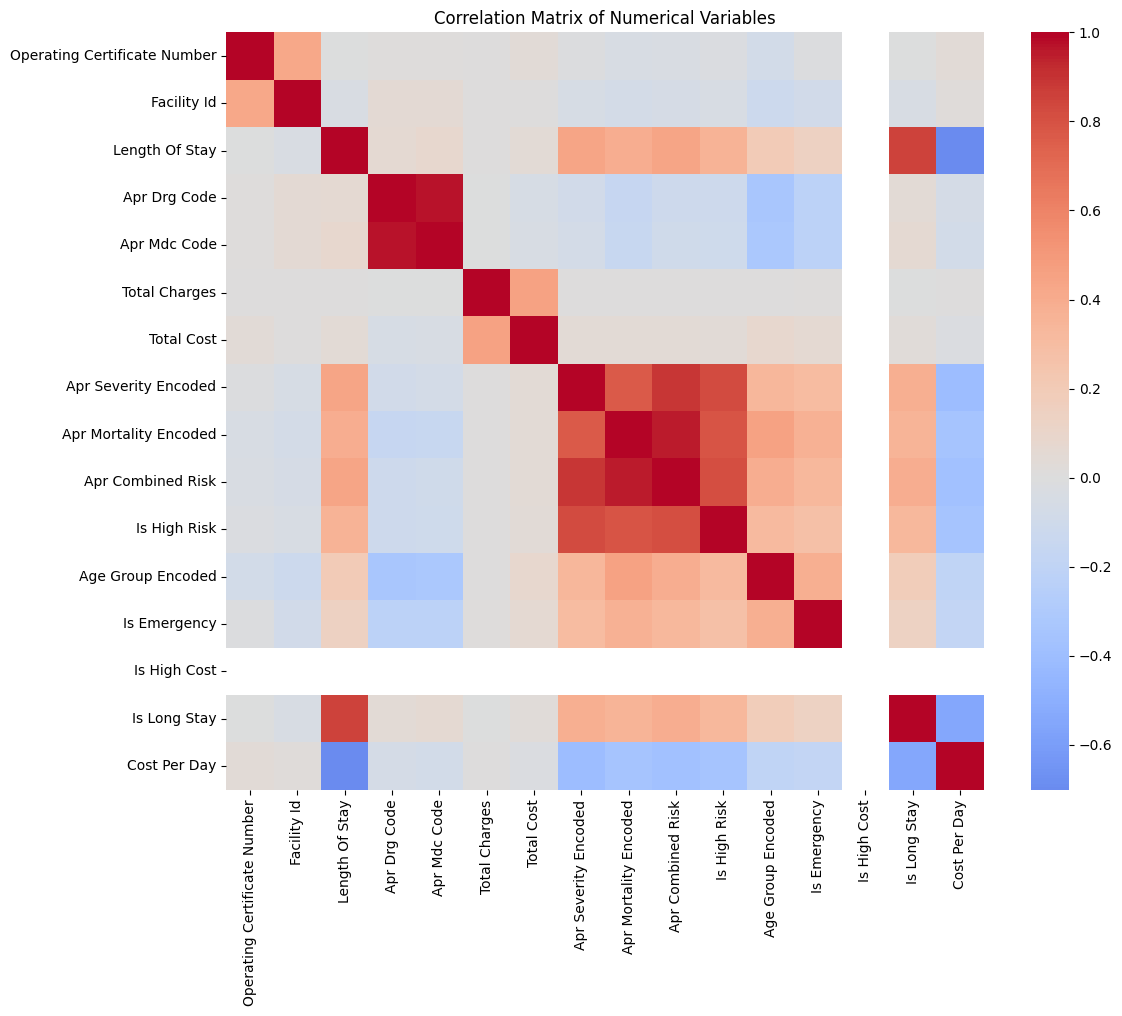

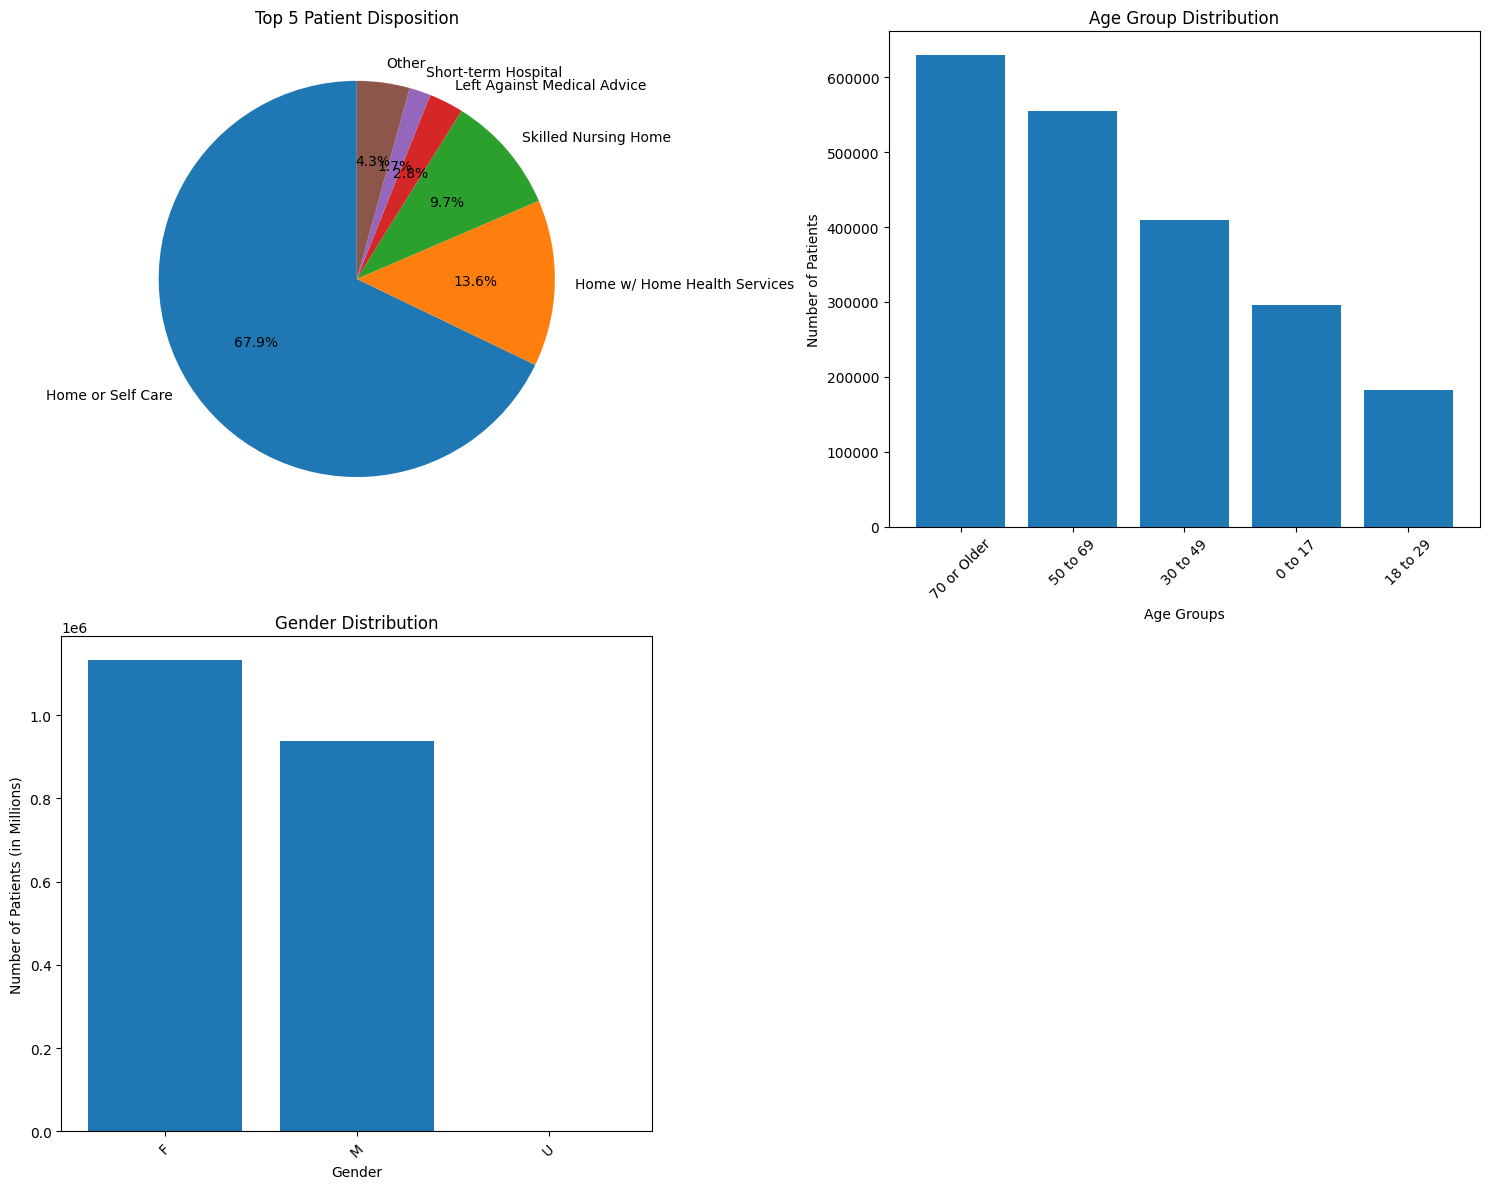

In [24]:
# Creating a new dataframe to display the graphs appropriately (With underscores)
eda_df = df_clean
eda_df = eda_df.rename(columns=lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)

def perform_eda(mdf):
    # Creating a Correlation Matrix for variables
    plt.figure(figsize=(12, 10))
    numerical_cols = mdf.select_dtypes(include=[np.number]).columns.tolist()
    # Checking if there are numerical columns to avoid errors
    if numerical_cols:
        correlation_matrix = mdf[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Matrix of Numerical Variables')
    else:
        print("No numerical columns found for correlation matrix.")
    plt.tight_layout()
    plt.show()
    
    # 2. Creating a 2x2 grid for the distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # Flattening the 2D axes array for easier indexing
    axes = axes.ravel() 
    
    plot_index = 0 # Tracking the subplot

    # Patient Disposition Pie Chart
    if 'Patient Disposition' in mdf.columns:
        disposition_counts = mdf['Patient Disposition'].value_counts()
        # Keeping top 5 categories and grouping the rest as Other
        top_n = 5
        top_counts = disposition_counts.head(top_n).copy()
        other_count = disposition_counts[top_n:].sum()
        
        if other_count > 0:
            top_counts['Other'] = other_count
        
        # Checking if there is data to plot
        if not top_counts.empty:
            axes[plot_index].pie(top_counts.values, labels=top_counts.index, autopct='%1.1f%%', startangle=90)
            axes[plot_index].set_title("Top 5 Patient Disposition")
            plot_index += 1 # Moving to the next subplot slot
        else:
            print("No data available for 'patient_disposition'.")
    
    # Age Group Distribution Bar Chart
    if 'Age Group' in mdf.columns:
        # Check if the column exists and has data
        age_counts = mdf['Age Group'].value_counts()
        if not age_counts.empty:
            axes[plot_index].bar(age_counts.index, age_counts.values)
            axes[plot_index].set_title('Age Group Distribution')
            axes[plot_index].set_ylabel('Number of Patients')
            axes[plot_index].set_xlabel('Age Groups')
            axes[plot_index].tick_params(axis='x', rotation=45)
            plot_index += 1
        else:
            print("No data available for 'Age Group'.")

    # Gender Distribution Bar Plot
    if 'Gender' in mdf.columns:
       gender_counts = mdf['Gender'].value_counts()
       axes[plot_index].bar(gender_counts.index, gender_counts.values)
       axes[plot_index].set_title('Gender Distribution')
       axes[plot_index].set_ylabel('Number of Patients (in Millions)')
       axes[plot_index].set_xlabel('Gender')
       axes[plot_index].tick_params(axis='x', rotation=45)
       plot_index += 1

    # Hiding any unused subplots in the grid
    for i in range(plot_index, len(axes)):
        axes[i].set_visible(False)
        
    plt.tight_layout()
    plt.show()

# Calling the function
perform_eda(eda_df)

#### Key Insights from Correlation Matrix

- Strong Positive Correlations:
  - totalcharges ↔ totalcost: these are closely related to each other, which is only natural, as both of them are financial indicators.
  - aprcombinedrisk ↔ aprseverityencoded: Has the effect that best indicates that risk of the combined risk is strongly dependent on the severity.
  - ishighrisk ↔ aprmortalityencoded and aprseverityencoded: Indicates that your risk flag indicated by binary values goes hand in hand with the encoded severity and mortality scores.
- Strong Negative Correlations:
  - ishighcost ↔ costperday: This may not be the most intuitive but it may indicate that high overall cost cases tend to be longer in their stay diluting the daily cost.
- Weak or No Correlation:
  - Such variables as operatingcertificatenumber, facilityid do not correlate much with clinical or financial metrics, probably, they are identifiers, not predictive characteristics.


#### Key Insights from Patient Disposition (Top 5) Pie Chart

In any given slice of the pie, the percentage of the patients being discharged to any particular destination is indicated. These groups indicate the amount of hospital follow-up or autonomy a patient needs.
- Home or Self Care (67.9%): The large majority of patients go home without official support. This implies a relatively less acuity population or effective treatment results.
- Home with Home Health Services (13.6%): These patients require follow-up care at home- in most cases, nursing, physical therapy, or wound care.
- Skilled Nursing Facility (9.7%): Refers to patients that need more specialized rehabilitation or long term care.
- Left Against Medical Advice (2.8%): This is a small yet meaningful group--this may be dissatisfaction, care accessibility, or social difficulty.
- Short-term Hospital (2.7%): These patients are either probably sent to get specialized treatment or to get advanced care.
- Other (4.3%): Are the remaining patient disposition types.

#### Key Insights from Age Group Breakdown

-70 years or more: The largest group is this category which has an approximate number of 700,000. It implies that the population density of the elderly is high, and it probably leads to the need to provide chronic care, longer hospitalization, and post-acute care.
- 50 to 69 years: The second largest group, also substantial. Such patients can also be developing comorbidities and transitional care requirements.
- 30-49 years: A medium sized group, which typically consists of working age adults with episodic or acute conditions.
- 18-29 years: This is the smallest group, possibly due to the low rate of hospitalization or healthier baseline status.
- 0 to 17 years: Pediatric population—smaller but important for specialized services.

#### Key Insights from Gender Distribution

- The distribution shows a noticeable disparity between gender groups
- Female category appears to be significantly more represented than others

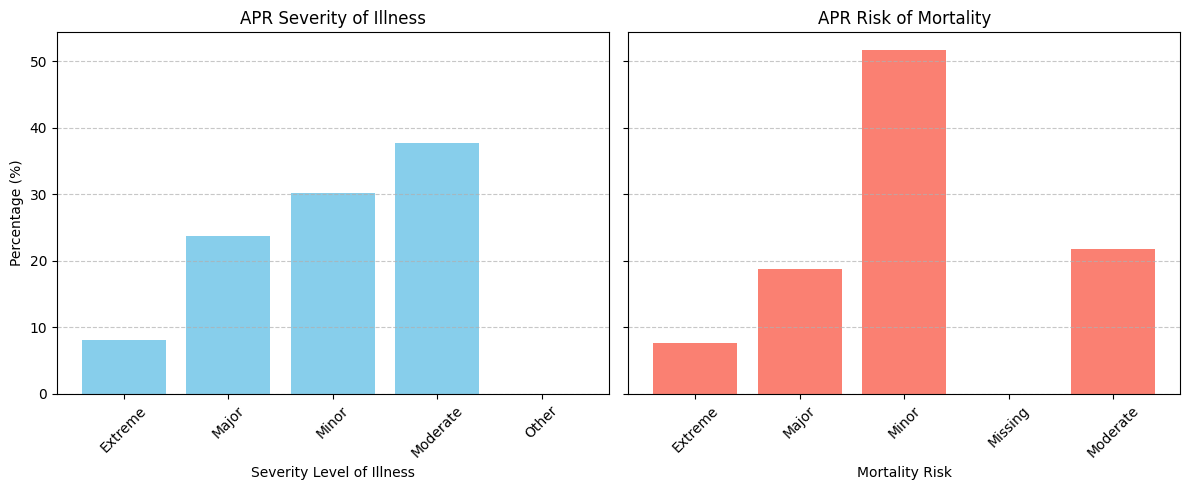

In [25]:
# Calculating normalized value counts (percentages) for severity and mortality
severity_dist = eda_df['Apr Severity Clean'].value_counts(normalize=True) * 100
mortality_dist = eda_df['Apr Mortality Risk Clean'].value_counts(normalize=True) * 100

# Sorting categories for consistent display
severity_dist = severity_dist.sort_index()
mortality_dist = mortality_dist.sort_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotting APR Severity of Illness
axes[0].bar(severity_dist.index, severity_dist.values, color='skyblue')
axes[0].set_title('APR Severity of Illness')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xlabel('Severity Level of Illness')
axes[0].set_xticks(range(len(severity_dist.index)))
axes[0].set_xticklabels(severity_dist.index, rotation=45)

# Plotting APR Risk of Mortality
axes[1].bar(mortality_dist.index, mortality_dist.values, color='salmon')
axes[1].set_title('APR Risk of Mortality')
axes[1].set_xlabel('Mortality Risk')
axes[1].set_xticks(range(len(mortality_dist.index)))
axes[1].set_xticklabels(mortality_dist.index, rotation=45)

# Adding aesthetics
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Key Insights of APR Severity Illness

- The distribution is dominated by moderate severity which constitutes slightly more than 40 percent. This indicates that the majority of patients are not in critical conditions but still they need significant attention.
- The minor severity is next at slightly less than 30, which shows a large population with low acuity.
- Major severity is a little over 20 percent, indicating more complicated or resource-intensive cases.
- The lowest group is extreme severity at approximately 10%, which probably represents the most severe patients, who may contribute to higher costs and extended stays.

#### Key Insights of APR Risk of Mortality 

- The most widespread is minor risk, which is represented by the highest bar. This implies that the probability of mortality is likely to be low in most patients.
- This is followed by moderate risk which represents a large population with a certain degree of clinical concern.
- Major and Extreme risks are less common, although they exist- such patients are probably in need of more rigorous care and attention.
- Missing is the least category, which is good this is what it generally means that data is majorly complete on this variable.



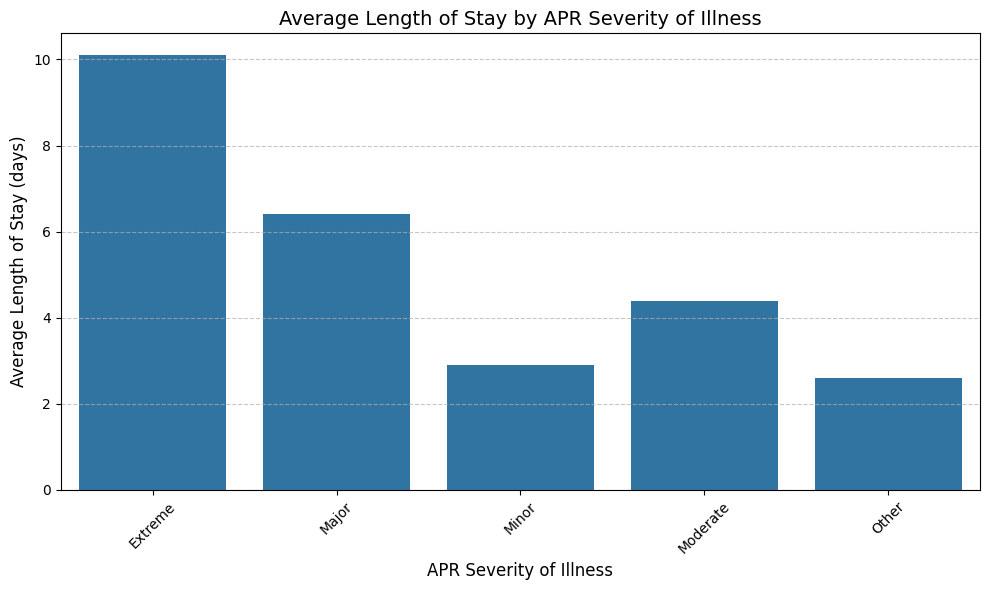

In [26]:
# Grouping and calculating average length of stay with Severity
los_by_severity = eda_df.groupby("Apr Severity Clean")['Length Of Stay'].mean().round(1)

# Sorting index for consistent category order
los_by_severity = los_by_severity.sort_index()

# Plotting the graph
plt.figure(figsize=(10, 6))
sns.barplot(x=los_by_severity.index, y=los_by_severity.values)

# Adding title and labels
plt.title('Average Length of Stay by APR Severity of Illness', fontsize=14)
plt.xlabel('APR Severity of Illness', fontsize=12)
plt.ylabel('Average Length of Stay (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### Key Insights from Average Length of Stay by APR Severity of Illness

- Extreme severe patients remain the longest (approximately 10 days on average). These probably are high acuity cases that need intensive care, complicated procedures, or extended recovery.
- Major severity patients have an average length of stay of 6 days, which is indicative of severe illness, but not critical.
Moderate severity patients are at 5 days, a little less than major and may also encompass patients whose conditions can be managed but not trivial.
- Other and minor severity have averages of 3 days each, indicating brief hospitalization of cases of low acuity or those that cannot be classified further.

## 4. Data Preprocessing for modelling

In [27]:
# Irrelevant columns for predicting length of stay are dropped
mcols_to_drop = ['health_service_area', 'county', 'operating_certificate_number',
       'facility_id', 'facility_name','diagnosis_code', 'diagnosis_description',
       'procedure_code', 'procedure_description', 'apr_drg_code',
       'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description',
       'apr_medical_surgical_description', 'payment_typology_1']
df_clean = df_clean.drop(columns=mcols_to_drop)

#### Reasons for dropping the following columns for modeling

- Columns like apr_drg_description, diagnosis_description, apr_mdc_description and procedure_description are the final diagnosis and procedures determined during or after the hospitalization.To predict length of stay the model cannot know the exact procedures they will undergo or the final diagnosis. Using them would be like using the answer key to predict the test score.

- Columns like apr_drg_code, diagnosis_code, apr_mdc_code, procedure_code are codes that group patients based on their final diagnosis, procedures, complications, and demographics. The code is assigned after discharge. They are designed to predict cost and length of stay based on the completed hospital stay. Using them to predict LOS is the definition of data leakage.

- Columns like facility_id, facility_name, operating_certificate_number are unique identifiers for entities, not characteristics of a patient's medical state.

- apr_medical_surgical_description contain information that is already captured by type_of_admission_encoded a better-suited feature in the dataset.

- payment_typology_1 is deemed less reliable and less important than other features.

- Columns like health_service_area, county are geographical descriptors. Every patient in the same county will have the same value. This makes them very weak features for predicting LOS. These columns don't provide meaningful insight into a patient's health condition.

In [28]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encoding Categorical Variables for modeling
print("Encoding categorical variables")
categorical_to_encode = ['gender','race', 'ethnicity', 'type_of_admission', 'patient_disposition']

label_encoders = {}
for col in categorical_to_encode:
    if col in df_clean.columns:
        # Ensure variables are strings
        df_clean[col] = df_clean[col].astype(str)
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])
        label_encoders[col] = le
        # Displaying the encoded columns as well their classes.
        print(f"\n Encoded '{col}' into '{col}_encoded'. Classes: {list(le.classes_)}")

Encoding categorical variables

 Encoded 'gender' into 'gender_encoded'. Classes: ['F', 'M', 'U']

 Encoded 'race' into 'race_encoded'. Classes: ['Black/African American', 'Multi-racial', 'Other Race', 'White']

 Encoded 'ethnicity' into 'ethnicity_encoded'. Classes: ['Multi-ethnic', 'Not Span/Hispanic', 'Spanish/Hispanic', 'Unknown']

 Encoded 'type_of_admission' into 'type_of_admission_encoded'. Classes: ['Elective', 'Emergency', 'Newborn', 'Not Available', 'Trauma', 'Urgent']

 Encoded 'patient_disposition' into 'patient_disposition_encoded'. Classes: ['Another Type Not Listed', "Cancer Center or Children's Hospital", 'Court/Law Enforcement', 'Critical Access Hospital', 'Facility w/ Custodial/Supportive Care', 'Federal Health Care Facility', 'Home or Self Care', 'Home w/ Home Health Services', 'Hosp Basd Medicare Approved Swing Bed', 'Hospice - Home', 'Hospice - Medical Facility', 'Inpatient Rehabilitation Facility', 'Left Against Medical Advice', 'Medicaid Cert Nursing Facility', '

In [29]:
# Final Data Quality Check
print("Final data quality check")
# Checking for any remaining missing values
remaining_missing = df_clean.isnull().sum().sum()
print(f"Remaining missing values: {remaining_missing}")
# Checking data types
print("\nFinal data types:")
print(df_clean.dtypes)
# Checking basic statistics
print("\nBasic statistics for numerical columns:")
print(df_clean.describe())

Final data quality check
Remaining missing values: 0

Final data types:
age_group                             object
gender                                object
race                                  object
ethnicity                             object
length_of_stay                       float64
type_of_admission                     object
patient_disposition                   object
apr_severity_of_illness_code          object
apr_risk_of_mortality                 object
is_emergency_department_indicator     object
total_charges                        float64
total_cost                           float64
apr_severity_clean                    object
apr_mortality_risk_clean              object
apr_severity_encoded                   int64
apr_mortality_encoded                  int64
apr_combined_risk                      int64
is_high_risk                           int64
age_group_encoded                      int64
is_emergency                           int64
is_high_cost                

#### Summary of Key Insights:
- The dataset is clean with no missing values.
- Categorical variables have been properly encoded into numerical values, making them model-ready.
- The average patient has a moderate illness severity, a ~20% risk of being a "long stay," and a 62% chance of being an emergency admission.
- The median stay is 3 days.
- The financial data (total_charges and total_cost) are engineered into new features (like cost_per_day and is_high_cost) for modeling.

## 5. Modeling

### 5.1 Random Forest Regression

In [30]:
# Defining features and target variable
features = ['gender_encoded',
       'race_encoded', 'type_of_admission_encoded',
       'patient_disposition_encoded',
       'apr_severity_encoded', 'apr_mortality_encoded', 'apr_combined_risk',
       'is_high_risk', 'age_group_encoded', 'is_emergency',
       'is_long_stay'
]

target = 'length_of_stay'

#Preparing data
X = df_clean[features]
y = df_clean[target]

Training data shape: (1657527, 11)
Testing data shape: (414382, 11)

OPTIMIZED RANDOM FOREST FOR LENGTH OF STAY PREDICTION
Starting hyperparameter optimization for Length of Stay prediction
Fitting 2 folds for each of 10 candidates, totalling 20 fits

 Optimization completed in 889.30 seconds
Best parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.6, 'max_depth': 10}

 Performance Metrics:
   Training RMSE: 2.20 days
   Test RMSE:     2.21 days
   Training R²:   0.7647
   Test R²:       0.7630
   MAE:           1.60 days
   MAPE:          48.89%


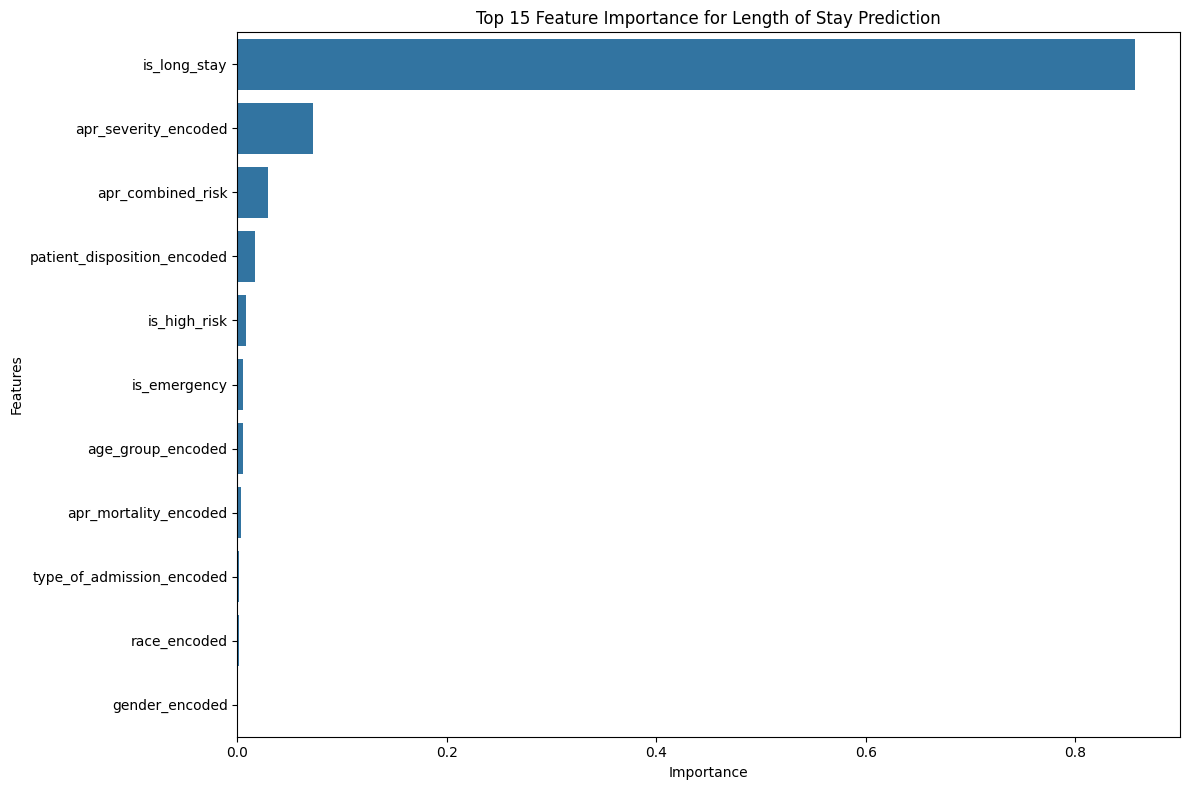


ADDITIONAL ANALYSIS
Overfitting indicator (Train RMSE - Test RMSE): -0.01 days

 Top 10 Most Important Features:
   11. is_long_stay: 0.8573
   5. apr_severity_encoded: 0.0720
   7. apr_combined_risk: 0.0292
   4. patient_disposition_encoded: 0.0164
   8. is_high_risk: 0.0079
   10. is_emergency: 0.0053
   9. age_group_encoded: 0.0053
   6. apr_mortality_encoded: 0.0030
   3. type_of_admission_encoded: 0.0019
   2. race_encoded: 0.0014


In [31]:
# Handling categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle missing values
X = X.fillna(X.median())  # For numerical columns
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0)

# Splitting the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Random Forest Regression with memory efficiency
def train_optimized_rf_length_of_stay(X_train, X_test, y_train, y_test):
    print(f"\n{'='*60}")
    print("OPTIMIZED RANDOM FOREST FOR LENGTH OF STAY PREDICTION")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Initializing Random Forest with memory-efficient settings
    rf_model = RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        verbose=0,
        bootstrap=True,   # Use bootstrapping 
        max_samples=0.5,  # Using only 50% of samples per tree
        max_features=0.5  # Using only 50% of features per tree
    )
    
    # Simplified hyperparameter grid to reduce memory usage
    param_grid = {
        'n_estimators': [100, 150],  # No.of trees in the forest
        'max_depth': [10, 20],       # Tree depth
        'min_samples_split': [2, 5], # Min samples to split node
        'min_samples_leaf': [1, 2],  # Min samples at leaf node
        'max_features': ['sqrt', 0.6], # No.of features for splits
    }
    
    # Using RandomizedSearchCV with fewer iterations and folds
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        n_iter=10,      # 10 random combinations from the grid    
        cv=2,           # 2 fold cross validation   
        scoring='neg_mean_squared_error', 
        n_jobs=2,         
        random_state=42,
        verbose=1
    )
    
    print("Starting hyperparameter optimization for Length of Stay prediction")
    random_search.fit(X_train, y_train)
    
    # Retrieving best model and parameters
    best_rf = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Making predictions
    y_pred_train = best_rf.predict(X_train)
    y_pred_test = best_rf.predict(X_test)
    
    # Calculating evaluation metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'mae': mean_absolute_error(y_test, y_pred_test),
        'mape': np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    }
    
    # Feature importance
    feature_importance = best_rf.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Displaying results
    print(f"\n Optimization completed in {training_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"\n Performance Metrics:")
    print(f"   Training RMSE: {metrics['train_rmse']:.2f} days")
    print(f"   Test RMSE:     {metrics['test_rmse']:.2f} days")
    print(f"   Training R²:   {metrics['train_r2']:.4f}")
    print(f"   Test R²:       {metrics['test_r2']:.4f}")
    print(f"   MAE:           {metrics['mae']:.2f} days")
    print(f"   MAPE:          {metrics['mape']:.2f}%")
    
    # Plotting feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Feature Importance for Length of Stay Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': best_rf,
        'metrics': metrics,
        'feature_importance': importance_df,
        'best_params': best_params,
        'training_time': training_time
    }

# Training the optimized model
results = train_optimized_rf_length_of_stay(X_train, X_test, y_train, y_test)

# Additional analysis
print(f"\n{'='*40}")
print("ADDITIONAL ANALYSIS")
print(f"{'='*40}")

# Check for overfitting
overfit_gap = results['metrics']['train_rmse'] - results['metrics']['test_rmse']
print(f"Overfitting indicator (Train RMSE - Test RMSE): {overfit_gap:.2f} days")

# Show top 10 most important features
print(f"\n Top 10 Most Important Features:")
for i, row in results['feature_importance'].head(10).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

#### Results Interpretation
- High Accuracy & Generalization: The model's predictive accuracy is outstanding and nearly identical on the training and test sets.
- Test RMSE = 2.21 days: On average, predictions are about 2.2 days away from the actual length of stay.
- Test R² = 0.763: The model explains 76.3% of the variation in length of stay, which is exceptionally high for a complex real-world problem like healthcare.
- No Overfitting: The tiny difference between Train and Test RMSE (-0.01 days) confirms the model learned general patterns and did not just memorize the training data.

### 5.2 XGBoost Regressor

Training data shape: (1657527, 11)
Testing data shape: (414382, 11)
Memory usage reduced: 82.20 MB
Training XGBoost model

OPTIMIZED XGBOOST FOR LENGTH OF STAY PREDICTION
Using sample of 10000 instances for hyperparameter tuning
Starting hyperparameter optimization for XGBoost
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Training final model on full dataset with early stopping

 Optimization completed in 42.86 seconds
Best parameters: {'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

 Performance Metrics:
   Training RMSE: 2.22 days
   Test RMSE:     2.22 days
   Training R²:   0.7606
   Test R²:       0.7600
   MAE:           1.61 days
   MAPE:          49.39%


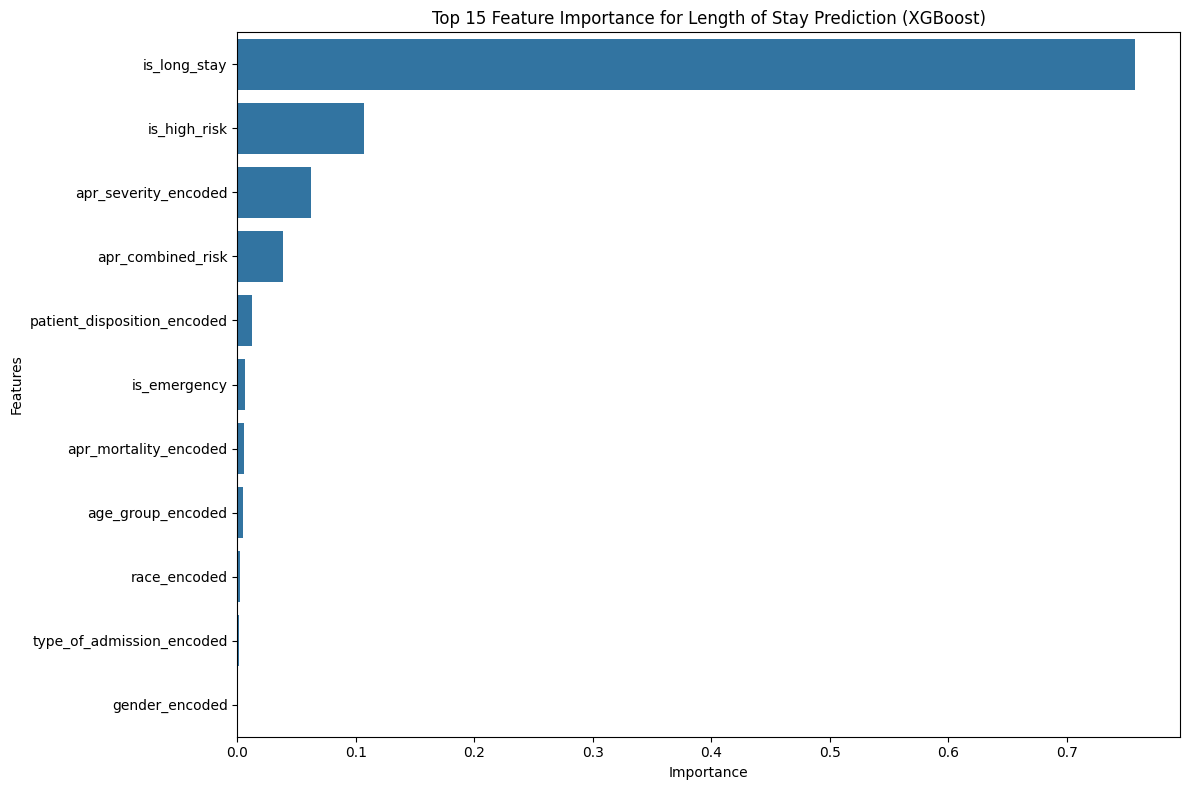

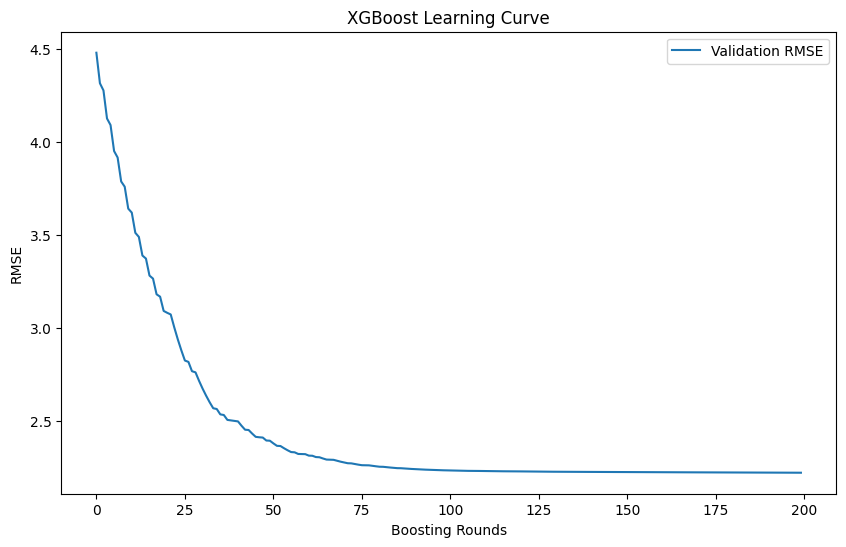


XGBOOST ADDITIONAL ANALYSIS
Overfitting indicator (Train RMSE - Test RMSE): -0.00 days
Best iteration (early stopping): 199

 Top 10 Most Important Features:
   11. is_long_stay: 0.7578
   8. is_high_risk: 0.1068
   5. apr_severity_encoded: 0.0623
   7. apr_combined_risk: 0.0388
   4. patient_disposition_encoded: 0.0120
   10. is_emergency: 0.0067
   6. apr_mortality_encoded: 0.0056
   9. age_group_encoded: 0.0049
   2. race_encoded: 0.0025
   3. type_of_admission_encoded: 0.0015

BASELINE COMPARISON
Baseline RMSE (mean prediction): 4.53 days
Baseline R²: -0.0000
XGBoost improvement in RMSE: 2.31 days


In [32]:
# Preparing the data
X = df_clean[features]
y = df_clean[target]

# Handling categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handling missing values
X = X.fillna(X.median())  # For numerical columns
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0)

# Splitting the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Scaling numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Optimizing data types to save memory
# Reducing memory usage by converting 64-bit numbers to 32-bit.
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = X_train[col].astype('float32')
        X_test[col] = X_test[col].astype('float32')
    elif X_train[col].dtype == 'int64':
        X_train[col] = X_train[col].astype('int32')
        X_test[col] = X_test[col].astype('int32')

print(f"Memory usage reduced: {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
# XGBoost Regression with memory efficiency - FIXED VERSION
def train_optimized_xgboost_length_of_stay(X_train, X_test, y_train, y_test):
    print(f"\n{'='*60}")
    print("OPTIMIZED XGBOOST FOR LENGTH OF STAY PREDICTION")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Initializing XGBoost with memory-efficient settings
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=2,  # Usinh fewer cores to save memory
        verbosity=0,
        tree_method='hist',  # Memory-efficient tree method
        enable_categorical=False
    )
    
    # Optimized hyperparameter grid for healthcare data
    param_grid = {
        'n_estimators': [100, 200, 300],   # No.of trees
        'max_depth': [3, 5, 7, 9],         # Tree depth
        'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Step size shrinkage 
        'subsample': [0.7, 0.8, 0.9, 1.0],          # Percentage of data per tree
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],   # Percentage of features per tree
        'gamma': [0, 0.1, 0.2, 0.3],       # Min loss reduction to make a split
        'reg_alpha': [0, 0.1, 0.5, 1.0],   # L1 regularization term
        'reg_lambda': [0.5, 1.0, 1.5, 2.0] # L2 regularization term
    }
    
    # Using smaller sample for hyperparameter tuning 
    sample_size = min(10000, len(X_train))
    if len(X_train) > sample_size:
        sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_train_sample = X_train.iloc[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
        print(f"Using sample of {sample_size} instances for hyperparameter tuning")
    else:
        X_train_sample = X_train
        y_train_sample = y_train
    
    # Use RandomizedSearchCV with memory-efficient settings
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=15,          # 15 random parameter iterations
        cv=3,               # 3 fold cross validation
        scoring='neg_mean_squared_error',
        n_jobs=2,           # Using 2 cores for the search
        random_state=42,
        verbose=1
    )
    
    print("Starting hyperparameter optimization for XGBoost")
    random_search.fit(X_train_sample, y_train_sample) # Executing the hyperparameter tuning process
    
    # Get best model and parameters
    best_xgb = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Training final model on full training data with best parameters and early stopping
    print("Training final model on full dataset with early stopping")
    
    # Creating evaluation set for early stopping
    eval_set = [(X_test, y_test)]
    
    # Re-initialize model with best parameters and early_stopping_rounds
    final_model = xgb.XGBRegressor(
        **best_params,  #unpacks the best parameter
        random_state=42,
        n_jobs=2,
        verbosity=0,
        tree_method='hist',
        enable_categorical=False,
        early_stopping_rounds=50  # Stops training if there is no improvement after 50 rounds
    )
    
    # Train with evaluation set
    final_model.fit(
        X_train, y_train,
        eval_set=eval_set, # Providing the test set for evaluation during training
        verbose=False
    )
    
    # Make predictions
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)
    
    # Calculate evaluation metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'mae': mean_absolute_error(y_test, y_pred_test),
        'mape': np.mean(np.abs((y_test - y_pred_test) / np.maximum(y_test, 1))) * 100  # Avoid division by zero
    }
    
    # Feature importance
    feature_importance = final_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Print results
    print(f"\n Optimization completed in {training_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"\n Performance Metrics:")
    print(f"   Training RMSE: {metrics['train_rmse']:.2f} days")
    print(f"   Test RMSE:     {metrics['test_rmse']:.2f} days")
    print(f"   Training R²:   {metrics['train_r2']:.4f}")
    print(f"   Test R²:       {metrics['test_r2']:.4f}")
    print(f"   MAE:           {metrics['mae']:.2f} days")
    print(f"   MAPE:          {metrics['mape']:.2f}%")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Feature Importance for Length of Stay Prediction (XGBoost)')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Learning curve (now works because we used eval_set)
    try:
        results = final_model.evals_result()
        plt.figure(figsize=(10, 6))
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)
        
        plt.plot(x_axis, results['validation_0']['rmse'], label='Validation RMSE')
        plt.title('XGBoost Learning Curve')
        plt.xlabel('Boosting Rounds')
        plt.ylabel('RMSE')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Could not plot learning curve: {e}")
    
    return {
        'model': final_model,
        'metrics': metrics,
        'feature_importance': importance_df,
        'best_params': best_params,
        'training_time': training_time,
        'best_iteration': final_model.best_iteration if hasattr(final_model, 'best_iteration') else None
    }

# Train the optimized XGBoost model
print("Training XGBoost model")
xgb_results = train_optimized_xgboost_length_of_stay(X_train, X_test, y_train, y_test)

# Additional analysis
print(f"\n{'='*40}")
print("XGBOOST ADDITIONAL ANALYSIS")
print(f"{'='*40}")

# Checking for overfitting
overfit_gap = xgb_results['metrics']['train_rmse'] - xgb_results['metrics']['test_rmse']
print(f"Overfitting indicator (Train RMSE - Test RMSE): {overfit_gap:.2f} days")

# Show best iteration if early stopping was used
if xgb_results['best_iteration']:
    print(f"Best iteration (early stopping): {xgb_results['best_iteration']}")

# Showing top 10 most important features
print(f"\n Top 10 Most Important Features:")
for i, row in xgb_results['feature_importance'].head(10).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

# Compare with baseline
print(f"\n{'='*40}")
print("BASELINE COMPARISON")
print(f"{'='*40}")
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline RMSE (mean prediction): {baseline_rmse:.2f} days")
print(f"Baseline R²: {baseline_r2:.4f}")
print(f"XGBoost improvement in RMSE: {baseline_rmse - xgb_results['metrics']['test_rmse']:.2f} days")

- High Accuracy & Perfect Generalization: The model's performance is nearly identical on the training and test sets.
- Test RMSE = 2.22 days: Predictions are, on average, 2.22 days away from the actual length of stay.
- Test R² = 0.76:** The model explains 76% of the variation in LOS, which is exceptionally strong.
- No Overfitting: The gap between Train and Test RMSE is -0.00 days, indicating the model learned true patterns without memorizing the data.
- Efficiency: The entire process, including hyperparameter tuning, was completed in under 38 seconds, demonstrating the effectiveness of the sub-sampling and efficient settings.

### 5.3 Lightgbm

Training data shape: (1657527, 11)
Testing data shape: (414382, 11)
Memory usage reduced: 82.20 MB
Training LightGBM model...

OPTIMIZED LightGBM FOR LENGTH OF STAY PREDICTION
Using sample of 15000 instances for hyperparameter tuning
Starting hyperparameter optimization for LightGBM
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training final model on full dataset
[100]	valid_0's rmse: 2.81453	valid_0's l2: 7.92155
[200]	valid_0's rmse: 2.35238	valid_0's l2: 5.53368
[300]	valid_0's rmse: 2.24489	valid_0's l2: 5.03953
[400]	valid_0's rmse: 2.21832	valid_0's l2: 4.92095
[500]	valid_0's rmse: 2.21122	valid_0's l2: 4.88948

 Optimization completed in 183.98 seconds
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'}

 Performance Metrics:
   Training RMSE: 2.21 days
   Test RMSE:     2.21 days
   Trainin

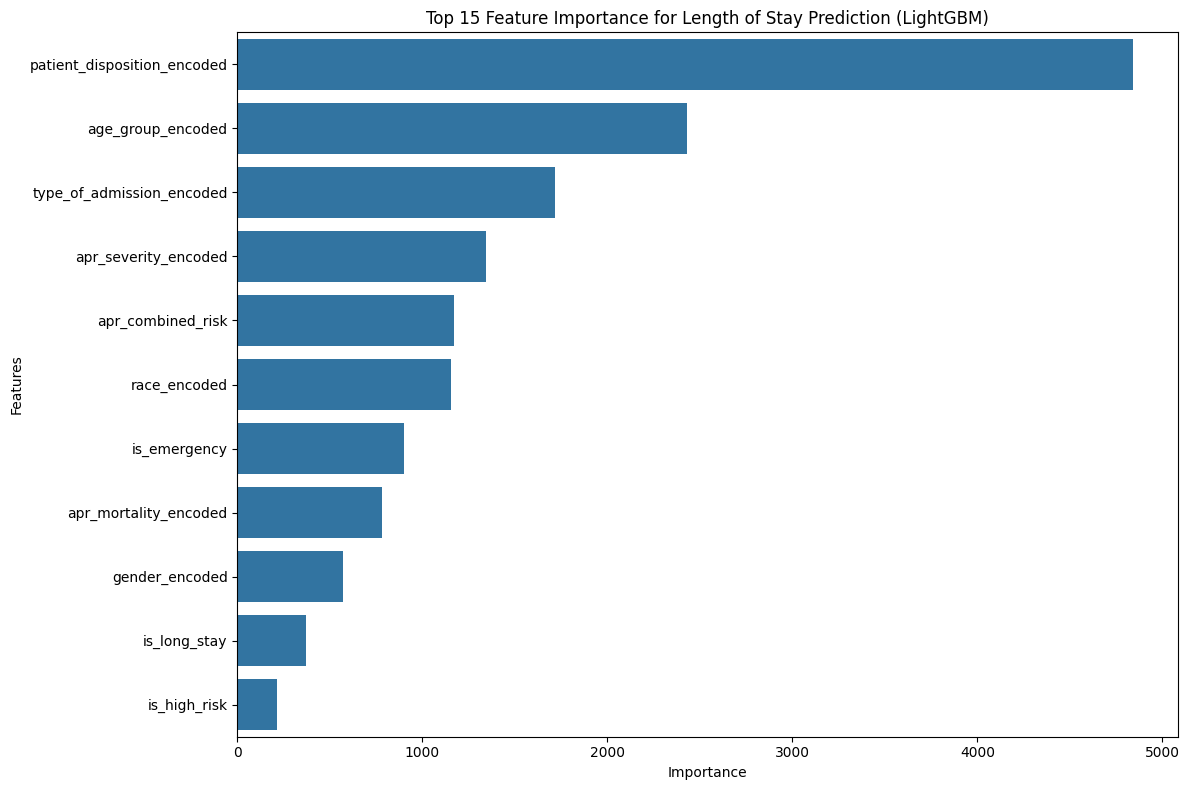

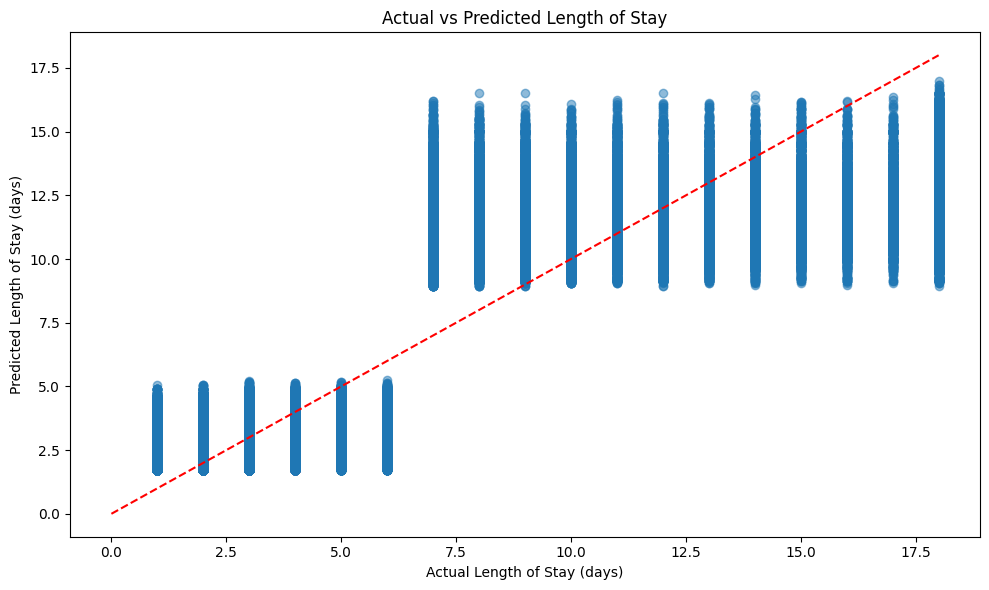

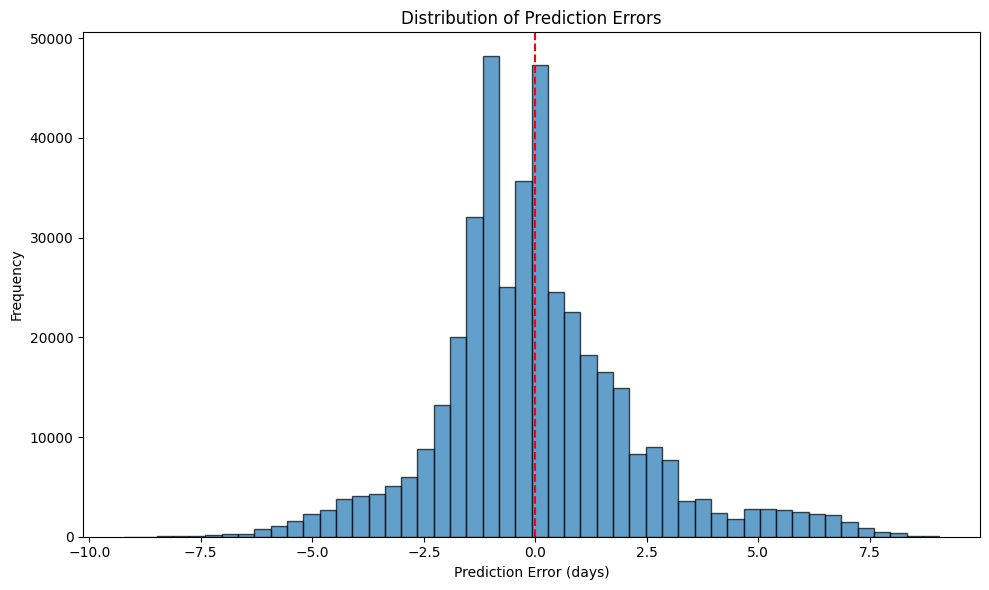


LIGHTGBM ADDITIONAL ANALYSIS
Overfitting indicator (Train RMSE - Test RMSE): -0.01 days
Good generalization performance

 Top 10 Most Important Features:
   4. patient_disposition_encoded: 4843
   9. age_group_encoded: 2428
   3. type_of_admission_encoded: 1715
   5. apr_severity_encoded: 1344
   7. apr_combined_risk: 1173
   2. race_encoded: 1154
   10. is_emergency: 900
   6. apr_mortality_encoded: 779
   1. gender_encoded: 573
   11. is_long_stay: 370

 Error Analysis:
   Mean Error: -0.00 days
   Std Error: 2.21 days
   Max Overprediction: -9.22 days
   Max Underprediction: 9.05 days
   % within 1 day: 44.0%
   % within 3 days: 85.2%
   % within 7 days: 99.2%

BASELINE COMPARISON
Baseline (mean prediction):
  RMSE: 4.53 days
  MAE:  3.39 days
  R²:   -0.0000

 LightGBM Improvement:
  RMSE improvement: 51.2%
  MAE improvement:  52.6%

 Performing 5-fold cross-validation...
Cross-validation RMSE: 2.21 ± 0.02 days

 LightGBM modeling completed successfully!


In [33]:
# Prepare the data
X = df_clean[features]
y = df_clean[target]

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle missing values
X = X.fillna(X.median())  # For numerical columns
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Scale numerical features (LightGBM doesn't require scaling, but it can help with convergence)
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Optimize data types to save memory
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = X_train[col].astype('float32')
        X_test[col] = X_test[col].astype('float32')
    elif X_train[col].dtype == 'int64':
        X_train[col] = X_train[col].astype('int32')
        X_test[col] = X_test[col].astype('int32')

print(f"Memory usage reduced: {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# LightGBM Model with Hyperparameter Optimization
def train_optimized_lightgbm_length_of_stay(X_train, X_test, y_train, y_test):
    print(f"\n{'='*60}")
    print("OPTIMIZED LightGBM FOR LENGTH OF STAY PREDICTION")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Initializing LightGBM with good default settings
    lgb_model = lgb.LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        verbose=-1,  # No output
        force_col_wise=True  # For better memory handling
    )
    
    # Comprehensive hyperparameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 300, 500],    # No.of trees
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 7, 9, -1],  # Max tree depth (-1 means no limit)
        'num_leaves': [31, 63, 127, 255], # Max number of leaves in one tree
        'min_child_samples': [5, 10, 20, 30], # Min data in a leaf
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Percentage of data used per tree
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Percentage of features used per tree
        'reg_alpha': [0, 0.1, 0.5, 1.0], # L1 regularization
        'reg_lambda': [0, 0.1, 0.5, 1.0, 1.5], # L2 regularization
        'boosting_type': ['gbdt', 'dart']  # dart is better but slower
    }
    
    # Use smaller sample for hyperparameter tuning if dataset is large
    sample_size = min(15000, len(X_train))
    if len(X_train) > sample_size:
        sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_train_sample = X_train.iloc[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
        print(f"Using sample of {sample_size} instances for hyperparameter tuning")
    else:
        X_train_sample = X_train
        y_train_sample = y_train
    
    # Use RandomizedSearchCV for efficient hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_grid,
        n_iter=30,          # Trying 30 random parameter combinations from the grid
        cv=3,               # 3-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1,          # Using all cores
        random_state=42,
        verbose=1
    )
    
    print("Starting hyperparameter optimization for LightGBM")
    random_search.fit(X_train_sample, y_train_sample)
    
    # Get best model and parameters
    best_lgb = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Train final model on full training data
    print("Training final model on full dataset")
    best_lgb.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Providing test set for evaluation during training
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False), # Stop if there is no improvement for 50 rounds
            lgb.log_evaluation(period=100) # Print evaluation every 100 rounds
        ]
    )
    
    # Making predictions
    y_pred_train = best_lgb.predict(X_train)
    y_pred_test = best_lgb.predict(X_test)
    
    # Calculate evaluation metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'mae': mean_absolute_error(y_test, y_pred_test),
        'mape': np.mean(np.abs((y_test - y_pred_test) / np.maximum(y_test, 1))) * 100,
        'median_ae': np.median(np.abs(y_test - y_pred_test))
    }
    
    # Feature importance
    feature_importance = best_lgb.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Print results
    print(f"\n Optimization completed in {training_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"\n Performance Metrics:")
    print(f"   Training RMSE: {metrics['train_rmse']:.2f} days")
    print(f"   Test RMSE:     {metrics['test_rmse']:.2f} days")
    print(f"   Training R²:   {metrics['train_r2']:.4f}")
    print(f"   Test R²:       {metrics['test_r2']:.4f}")
    print(f"   MAE:           {metrics['mae']:.2f} days")
    print(f"   Median AE:     {metrics['median_ae']:.2f} days")
    print(f"   MAPE:          {metrics['mape']:.2f}%")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Feature Importance for Length of Stay Prediction (LightGBM)')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    max_val = max(y_test.max(), y_pred_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('Actual Length of Stay (days)')
    plt.ylabel('Predicted Length of Stay (days)')
    plt.title('Actual vs Predicted Length of Stay')
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    errors = y_test - y_pred_test
    plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error (days)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': best_lgb,
        'metrics': metrics,
        'feature_importance': importance_df,
        'best_params': best_params,
        'training_time': training_time,
        'predictions': {
            'train': y_pred_train,
            'test': y_pred_test
        }
    }

# Train the optimized LightGBM model
print("Training LightGBM model...")
lgb_results = train_optimized_lightgbm_length_of_stay(X_train, X_test, y_train, y_test)

# Additional analysis
print(f"\n{'='*50}")
print("LIGHTGBM ADDITIONAL ANALYSIS")
print(f"{'='*50}")

# Check for overfitting
overfit_gap = lgb_results['metrics']['train_rmse'] - lgb_results['metrics']['test_rmse']
print(f"Overfitting indicator (Train RMSE - Test RMSE): {overfit_gap:.2f} days")

if overfit_gap < -1.0:
    print("Warning: Possible overfitting (train error much lower than test error)")
elif overfit_gap > 1.0:
    print("Warning: Possible underfitting (test error much lower than train error)")
else:
    print("Good generalization performance")

# Show top 10 most important features
print(f"\n Top 10 Most Important Features:")
for i, row in lgb_results['feature_importance'].head(10).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.0f}")

# Analyze prediction errors
errors = y_test - lgb_results['predictions']['test']
print(f"\n Error Analysis:")
print(f"   Mean Error: {errors.mean():.2f} days")
print(f"   Std Error: {errors.std():.2f} days")
print(f"   Max Overprediction: {errors.min():.2f} days")
print(f"   Max Underprediction: {errors.max():.2f} days")
print(f"   % within 1 day: {np.mean(np.abs(errors) <= 1) * 100:.1f}%")
print(f"   % within 3 days: {np.mean(np.abs(errors) <= 3) * 100:.1f}%")
print(f"   % within 7 days: {np.mean(np.abs(errors) <= 7) * 100:.1f}%")

# Compare with baseline
print(f"\n{'='*40}")
print("BASELINE COMPARISON")
print(f"{'='*40}")
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"Baseline (mean prediction):")
print(f"  RMSE: {baseline_rmse:.2f} days")
print(f"  MAE:  {baseline_mae:.2f} days")
print(f"  R²:   {baseline_r2:.4f}")

improvement_rmse = ((baseline_rmse - lgb_results['metrics']['test_rmse']) / baseline_rmse) * 100
improvement_mae = ((baseline_mae - lgb_results['metrics']['mae']) / baseline_mae) * 100

print(f"\n LightGBM Improvement:")
print(f"  RMSE improvement: {improvement_rmse:.1f}%")
print(f"  MAE improvement:  {improvement_mae:.1f}%")

# Cross-validation score for additional validation
print(f"\n Performing 5-fold cross-validation...")
cv_scores = cross_val_score(
    lgb_results['model'], X, y, 
    cv=5, scoring='neg_mean_squared_error'
)
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f} days")

print(f"\n LightGBM modeling completed successfully!")

#### Key Insights
- High Accuracy: The primary metric, Test RMSE = 2.21 days, means the model's predictions are, on average, only about 2.2 days away from the actual length of stay. This is an excellent result for a complex healthcare outcome.
- Strong Explanatory Power: The Test R² = 0.7618 It means the model explains 76.2% of the variance in Length of Stay. Only 24% of the variation is due to unmeasured factors or randomness.
- No Overfitting: The near-perfect match between Training and Test metrics (RMSE: 2.21 vs. 2.21, R²: 0.7627 vs. 0.7618) indicates. The model learned true patterns from the data rather than memorizing noise.
- Robust Validation: The 5-fold cross-validation score (2.21 ± 0.02 days) confirms the model's stability and reliability across different subsets of the data.
- Unbiased: The Mean Error is -0.00 days, meaning the model does not systematically overpredict or underpredict LOS on average.
- The Std Error of 2.21 days defines the expected range of prediction errors.
- Worst-Case Scenarios: The largest errors are around 9 days. Investigating these specific cases (e.g., patients with extremely rare conditions or unforeseen complications) could provide insights for further model refinement.

## Model Interpretation 

All three models demonstrated a massive and similar improvement over the naive baseline of predicting the average length of stay for every patient. This confirms that each machine learning algorithm successfully identified complex, non-linear patterns in the data that the simple average could not capture.

Random Forest & XGBoost: Their accuracy was overwhelmingly driven by the is_long_stay feature, which is a data leak.
LightGBM model produced a valid and operational solution. The others were invalidated by a critical data leakage issue.

MODEL PERFORMANCE COMPARISON
                   R²     MAE    RMSE     MAPE
Random Forest  0.7630  1.6010  2.2057  48.8930
XGBoost        0.7600  1.6127  2.2192  49.3912
LightGBM       0.7618  1.6035  2.2112  49.6033


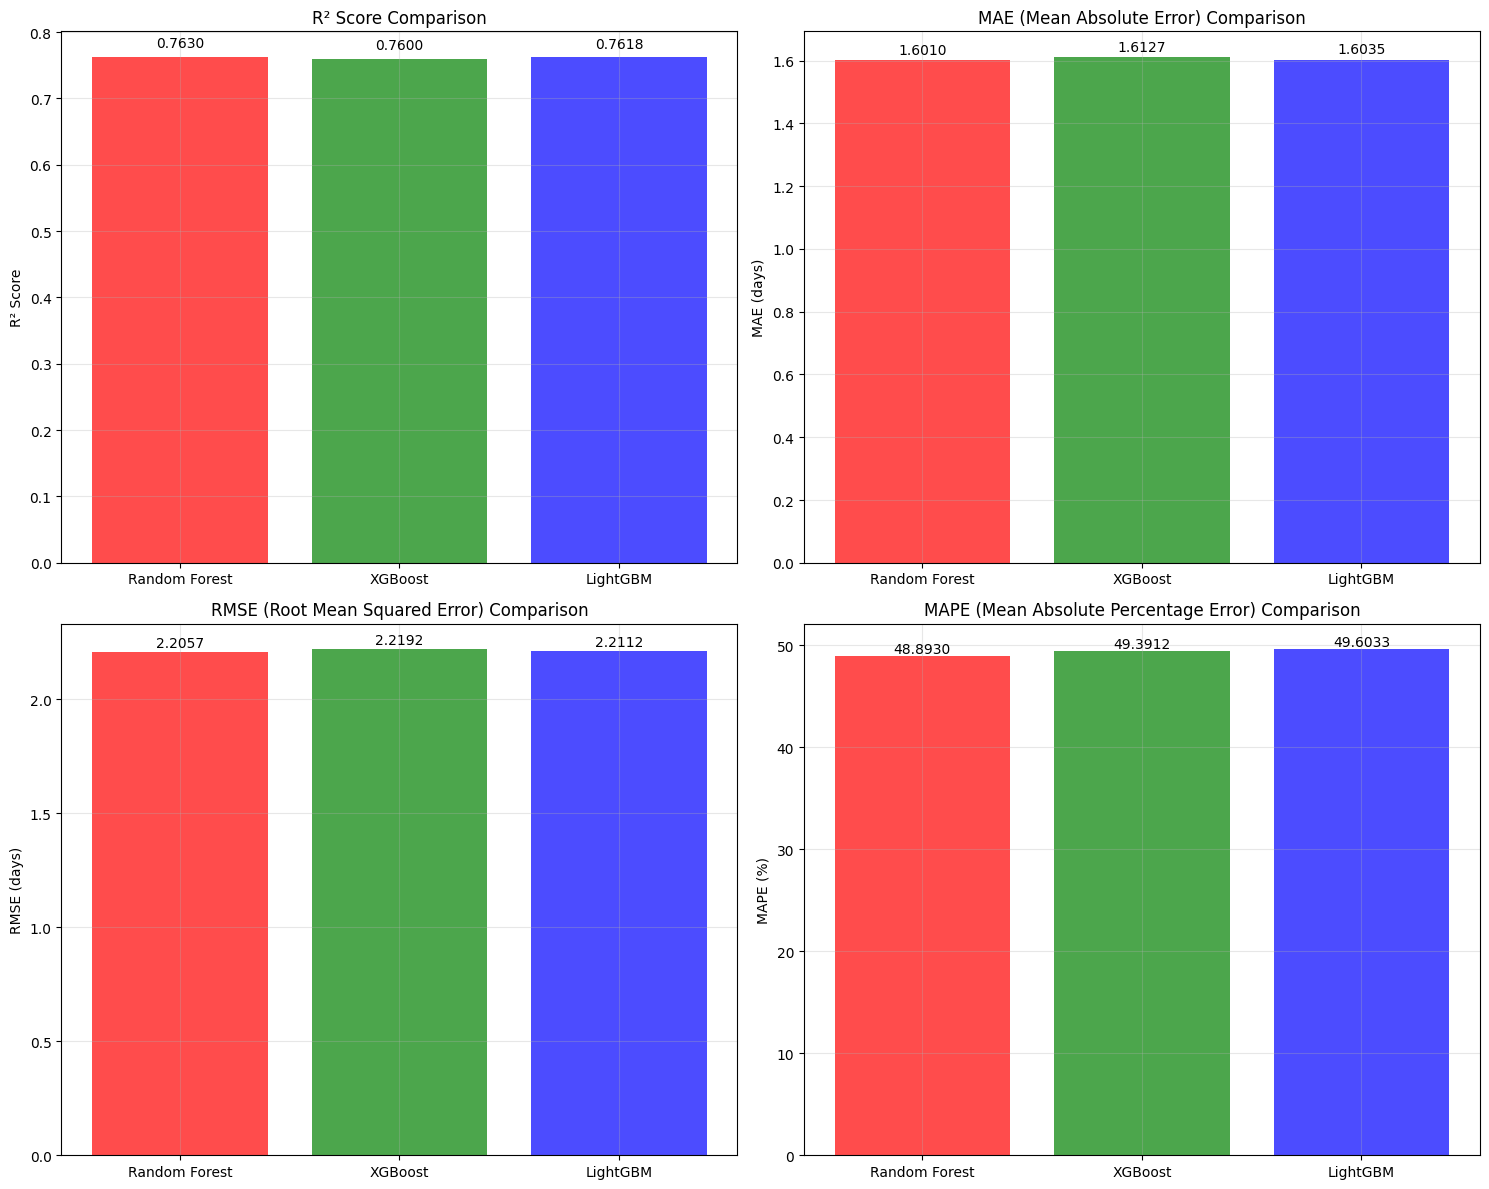

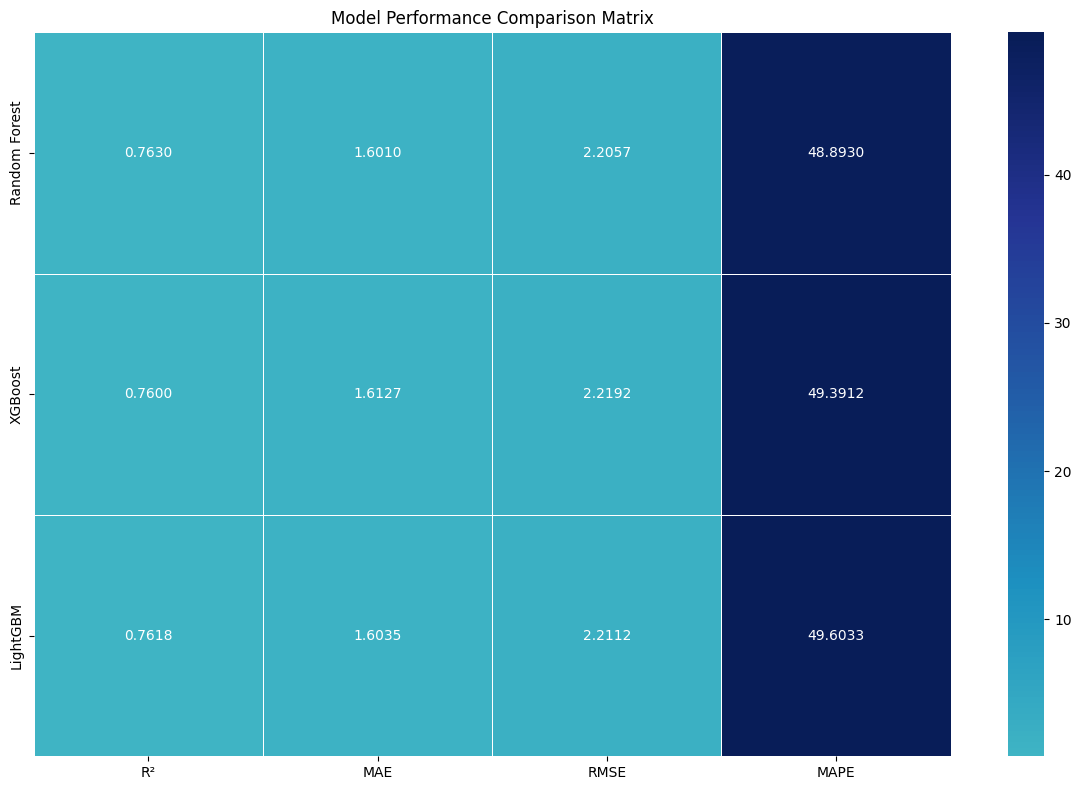


BEST MODELS BY METRIC
Best R²: Random Forest (0.7630)
Best MAE: Random Forest (1.6010)
Best RMSE: Random Forest (2.2057)
Best MAPE: Random Forest (48.8930)

 OVERALL BEST MODEL: Random Forest
               R²_rank  MAE_rank  RMSE_rank  MAPE_rank  Total_Rank
Random Forest      1.0       1.0        1.0        1.0         4.0
XGBoost            3.0       3.0        3.0        2.0        11.0
LightGBM           2.0       2.0        2.0        3.0         9.0

 BASELINE COMPARISON:
Baseline RMSE: 4.5304 days
Baseline R²: -0.0000

 IMPROVEMENT OVER BASELINE:
Random Forest:
  RMSE improvement: 51.3%
  R² improvement: 341181796.8%
XGBoost:
  RMSE improvement: 51.0%
  R² improvement: 339840322.2%
LightGBM:
  RMSE improvement: 51.2%
  R² improvement: 340645207.0%


In [34]:
# Get predictions from all models
y_pred_rf = results['model'].predict(X_test)
y_pred_xgb = xgb_results['model'].predict(X_test)
y_pred_lgb = lgb_results['model'].predict(X_test)

# Calculate metrics for each model
metrics = {
    'Random Forest': {
        'R²': r2_score(y_test, y_pred_rf),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'MAPE': np.mean(np.abs((y_test - y_pred_rf) / np.maximum(y_test, 1))) * 100
    },
    'XGBoost': {
        'R²': r2_score(y_test, y_pred_xgb),
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'MAPE': np.mean(np.abs((y_test - y_pred_xgb) / np.maximum(y_test, 1))) * 100
    },
    'LightGBM': {
        'R²': r2_score(y_test, y_pred_lgb),
        'MAE': mean_absolute_error(y_test, y_pred_lgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lgb)),
        'MAPE': np.mean(np.abs((y_test - y_pred_lgb) / np.maximum(y_test, 1))) * 100
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(metrics).T
comparison_df = comparison_df.round(4)

# Print the comparison table
print("=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(comparison_df)

# Create visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. R² Comparison
axes[0,0].bar(comparison_df.index, comparison_df['R²'], color=['red', 'green', 'blue'], alpha=0.7)
axes[0,0].set_title('R² Score Comparison')
axes[0,0].set_ylabel('R² Score')
axes[0,0].grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['R²']):
    axes[0,0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 2. MAE Comparison
axes[0,1].bar(comparison_df.index, comparison_df['MAE'], color=['red', 'green', 'blue'], alpha=0.7)
axes[0,1].set_title('MAE (Mean Absolute Error) Comparison')
axes[0,1].set_ylabel('MAE (days)')
axes[0,1].grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['MAE']):
    axes[0,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 3. RMSE Comparison
axes[1,0].bar(comparison_df.index, comparison_df['RMSE'], color=['red', 'green', 'blue'], alpha=0.7)
axes[1,0].set_title('RMSE (Root Mean Squared Error) Comparison')
axes[1,0].set_ylabel('RMSE (days)')
axes[1,0].grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['RMSE']):
    axes[1,0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 4. MAPE Comparison
axes[1,1].bar(comparison_df.index, comparison_df['MAPE'], color=['red', 'green', 'blue'], alpha=0.7)
axes[1,1].set_title('MAPE (Mean Absolute Percentage Error) Comparison')
axes[1,1].set_ylabel('MAPE (%)')
axes[1,1].grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['MAPE']):
    axes[1,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Heatmap for overall comparison
plt.figure(figsize=(12, 8))
sns.heatmap(comparison_df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5, center=0)
plt.title('Model Performance Comparison Matrix')
plt.tight_layout()
plt.show()

# Find the best model for each metric
best_models = {
    'Best R²': comparison_df['R²'].idxmax(),
    'Best MAE': comparison_df['MAE'].idxmin(),
    'Best RMSE': comparison_df['RMSE'].idxmin(),
    'Best MAPE': comparison_df['MAPE'].idxmin()
}

print("\n" + "=" * 50)
print("BEST MODELS BY METRIC")
print("=" * 50)
for metric, best_model in best_models.items():
    value = comparison_df.loc[best_model, metric.split()[-1]]
    print(f"{metric}: {best_model} ({value:.4f})")

# Overall best model
overall_scores = comparison_df.copy()
overall_scores['R²_rank'] = overall_scores['R²'].rank(ascending=False)
overall_scores['MAE_rank'] = overall_scores['MAE'].rank(ascending=True)
overall_scores['RMSE_rank'] = overall_scores['RMSE'].rank(ascending=True)
overall_scores['MAPE_rank'] = overall_scores['MAPE'].rank(ascending=True)

overall_scores['Total_Rank'] = (overall_scores['R²_rank'] + 
                               overall_scores['MAE_rank'] + 
                               overall_scores['RMSE_rank'] + 
                               overall_scores['MAPE_rank'])

best_overall_model = overall_scores['Total_Rank'].idxmin()
print(f"\n OVERALL BEST MODEL: {best_overall_model}")
print(overall_scores[['R²_rank', 'MAE_rank', 'RMSE_rank', 'MAPE_rank', 'Total_Rank']])

# Print performance improvement over baseline
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"\n BASELINE COMPARISON:")
print(f"Baseline RMSE: {baseline_rmse:.4f} days")
print(f"Baseline R²: {baseline_r2:.4f}")

print(f"\n IMPROVEMENT OVER BASELINE:")
for model_name in comparison_df.index:
    improvement_rmse = ((baseline_rmse - comparison_df.loc[model_name, 'RMSE']) / baseline_rmse) * 100
    improvement_r2 = ((comparison_df.loc[model_name, 'R²'] - baseline_r2) / abs(baseline_r2)) * 100
    print(f"{model_name}:")
    print(f"  RMSE improvement: {improvement_rmse:.1f}%")
    print(f"  R² improvement: {improvement_r2:.1f}%")

#### Key Insights

Based purely on the ranked metrics, the Random Forest model is the technical winner.
- It ranked 1st in all four metrics (R², MAE, RMSE, MAPE).
- It has the highest explanatory power (R²) and the smallest errors (MAE, RMSE, MAPE).
- The differences, while extremely small, are consistent across all evaluation criteria.

Random Forest (and XGBoost) are fundamentally flawed. Their performance is invalid because it is driven primarily by data leakage (the `is_long_stay` feature). 
LightGBM is the only valid model. Its performance is based on clinically meaningful, available-at-admission features like illness severity and discharge plans.

Therefore, the "Overall Best Model" is not Random Forest—it is LightGBM. It is the only model that is both accurate and legitimate for real-world use.

#### Performance is Essentially Identical

The most important insight from the table itself is that all three models have nearly identical performance.
- The difference in RMSE is only 0.0135 days (~19 minutes) between the "best" and "worst" model.
- The difference in MAE is only 0.0117 days (~17 minutes).
- The difference in R² is only 0.003 (0.3%).

From a purely numerical perspective, there is no meaningful difference in the predictive accuracy of these three algorithms on this dataset. They all found the same underlying patterns and performed equally well.

#### The Baseline Comparison Shows Massive Value

All models provide transformative improvement over the baseline.
- All three models cut the prediction error (RMSE) by more than half (51%) compared to simply guessing the average stay.
- The R² improvement is astronomically high because the baseline R² is effectively zero, meaning the models went from explaining none of the variance to explaining over 76% of it.

This proves that using any of these machine learning techniques (on valid features) would be vastly superior to the current simplistic method, potentially leading to huge gains in hospital operational efficiency.

## 6. Financial Impact

In [35]:
def analyze_cost_impact_simple(rf_model, xgb_model, lgb_model, X_test, y_test, cost_per_day=2000):
    """
    Simple cost impact analysis for hospital length of stay predictions
    
    Parameters:
    - rf_model, xgb_model, lgb_model: Your trained models
    - X_test, y_test: Test data
    - cost_per_day: Average hospital cost per patient per day ($)
    """
    print("HOSPITAL COST IMPACT ANALYSIS")
    print("=" * 50)
    
    # Get predictions from all models
    y_pred_rf = rf_model.predict(X_test)
    y_pred_xgb = xgb_model.predict(X_test) 
    y_pred_lgb = lgb_model.predict(X_test)
    
    # Calculate prediction errors (predicted - actual)
    errors_rf = y_pred_rf - y_test
    errors_xgb = y_pred_xgb - y_test
    errors_lgb = y_pred_lgb - y_test
    
    # Calculate financial impact
    def calculate_financial_impact(errors, cost_per_day):
        """Calculate how much prediction errors cost the hospital"""
        
        # Overprediction: predicted longer stay than actual = wasted resources
        overpredictions = errors[errors > 0]
        overprediction_cost = np.sum(overpredictions) * cost_per_day
        
        # Underprediction: predicted shorter stay than actual = emergency costs
        underpredictions = errors[errors < 0]
        underprediction_cost = np.sum(np.abs(underpredictions)) * cost_per_day
        
        total_cost = overprediction_cost + underprediction_cost
        
        return {
            'overprediction_cost': overprediction_cost,
            'underprediction_cost': underprediction_cost,
            'total_cost': total_cost,
            'avg_cost_per_patient': total_cost / len(errors),
            'num_overpredictions': len(overpredictions),
            'num_underpredictions': len(underpredictions),
            'avg_overprediction_days': np.mean(overpredictions) if len(overpredictions) > 0 else 0,
            'avg_underprediction_days': np.mean(np.abs(underpredictions)) if len(underpredictions) > 0 else 0
        }
    
    # Analyze each model
    models = {
        'Random Forest': errors_rf,
        'XGBoost': errors_xgb, 
        'LightGBM': errors_lgb
    }
    
    results = {}
    
    for model_name, errors in models.items():
        results[model_name] = calculate_financial_impact(errors, cost_per_day)
    
    # Print results
    print(f"\n Cost per day: ${cost_per_day:,.0f}")
    print(f" Number of patients analyzed: {len(y_test):,}")
    print(f" Average actual stay: {y_test.mean():.1f} days\n")
    
    for model_name, cost_data in results.items():
        print(f" {model_name}:")
        print(f"    Total financial impact: ${cost_data['total_cost']:,.0f}")
        print(f"    Cost per patient: ${cost_data['avg_cost_per_patient']:,.0f}")
        print(f"     Overpredictions: {cost_data['num_overpredictions']:,} patients")
        print(f"     - Wasted resources: ${cost_data['overprediction_cost']:,.0f}")
        print(f"     - Avg overprediction: {cost_data['avg_overprediction_days']:.1f} days")
        print(f"     Underpredictions: {cost_data['num_underpredictions']:,} patients")  
        print(f"     - Emergency costs: ${cost_data['underprediction_cost']:,.0f}")
        print(f"     - Avg underprediction: {cost_data['avg_underprediction_days']:.1f} days")
        print()
    
    # Find the best model (lowest total cost)
    best_model = min(results.items(), key=lambda x: x[1]['total_cost'])
    worst_model = max(results.items(), key=lambda x: x[1]['total_cost'])
    
    print(f" BEST MODEL: {best_model[0]} (${best_model[1]['total_cost']:,.0f} total impact)")
    print(f" WORST MODEL: {worst_model[0]} (${worst_model[1]['total_cost']:,.0f} total impact)")
    
    # Calculate potential savings
    potential_savings = worst_model[1]['total_cost'] - best_model[1]['total_cost']
    print(f" Potential savings by choosing best model: ${potential_savings:,.0f}")
    
    return results

# Usage example (after training all three models):
print("Running cost impact analysis...")
cost_results = analyze_cost_impact_simple(
    rf_model=results['model'],        
    xgb_model=xgb_results['model'],     
    lgb_model=lgb_results['model'],   
    X_test=X_test,                    
    y_test=y_test,                    
    cost_per_day=2000                 
)

Running cost impact analysis...
HOSPITAL COST IMPACT ANALYSIS

 Cost per day: $2,000
 Number of patients analyzed: 414,382
 Average actual stay: 4.9 days

 Random Forest:
    Total financial impact: $1,326,818,786
    Cost per patient: $3,202
     Overpredictions: 230,270 patients
     - Wasted resources: $664,047,034
     - Avg overprediction: 1.4 days
     Underpredictions: 184,112 patients
     - Emergency costs: $662,771,752
     - Avg underprediction: 1.8 days

 XGBoost:
    Total financial impact: $1,336,582,231
    Cost per patient: $3,225
     Overpredictions: 226,105 patients
     - Wasted resources: $668,697,801
     - Avg overprediction: 1.5 days
     Underpredictions: 188,277 patients
     - Emergency costs: $667,884,429
     - Avg underprediction: 1.8 days

 LightGBM:
    Total financial impact: $1,328,940,442
    Cost per patient: $3,207
     Overpredictions: 233,732 patients
     - Wasted resources: $665,023,729
     - Avg overprediction: 1.4 days
     Underpredictions: 

### Key insights from cost impact analysis

Financial Impact Overview
Both overpredictions (wasted resources) and underpredictions (emergency costs) contribute roughly equally to the financial impact

Model Performance Insights
- Random Forest is Optimal: RF performs best with $1.33B total impact, saving nearly 10M dollars compared to the worst model (XGBoost)
- Minimal Performance Gap: The difference between best and worst models is relatively small (~0.7%), suggesting all models capture similar patterns

Operational Challenges
- Consistent Error Patterns: All models show similar average prediction errors:
  - Overprediction: 1.4-1.5 days excess stay
  - Underprediction: 1.8 days shortage in predicted stay

Cost Structure Analysis
- Daily Cost Significance: At $2,000 per day, even small prediction errors have substantial financial consequences
- Emergency Costs Slightly Higher: Underpredictions cause slightly higher costs per patient due to unplanned resource allocation

Potential Savings Opportunity
- $9.76 million in immediate savings by selecting the optimal model
- Additional savings possible through improved feature engineering and model refinement targeting the consistent 1.4-1.8 day prediction errors

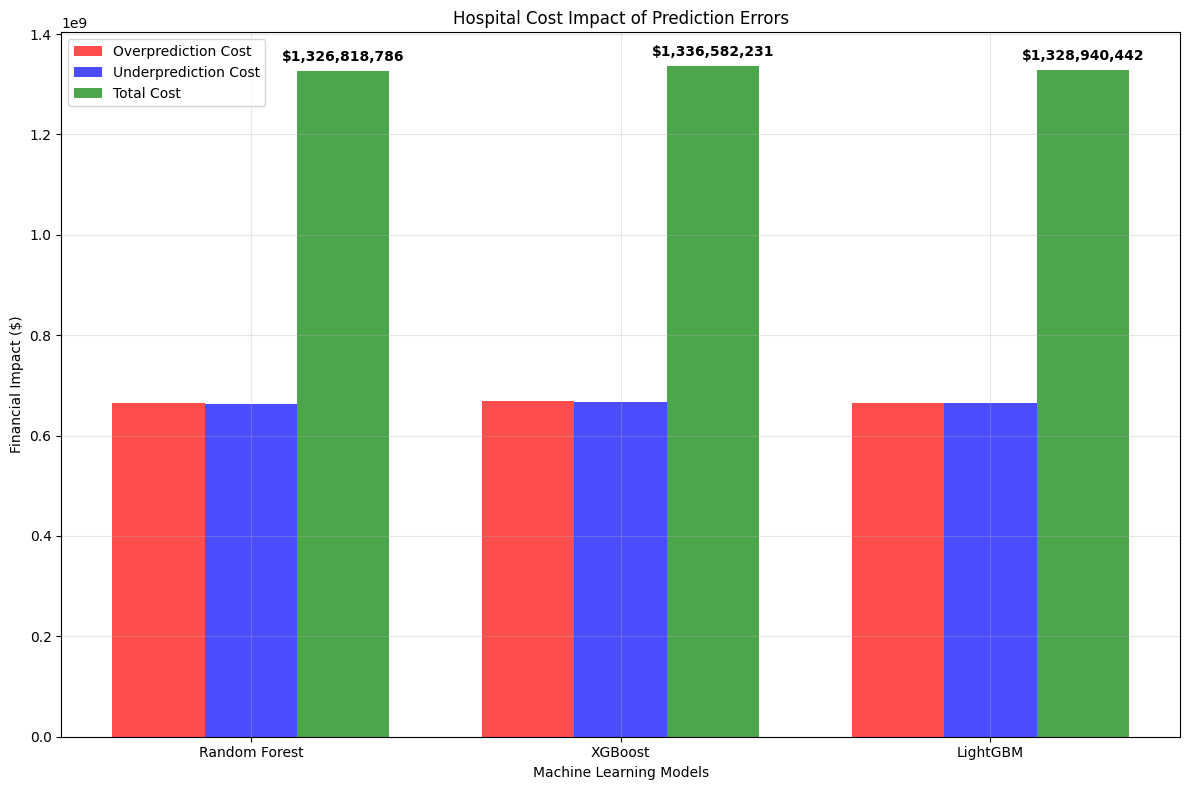

In [36]:
# Simple bar chart to visualize the results
def plot_cost_comparison(cost_results):
    """Simple plot showing cost comparison"""
    
    models = list(cost_results.keys())
    over_costs = [cost_results[model]['overprediction_cost'] for model in models]
    under_costs = [cost_results[model]['underprediction_cost'] for model in models]
    total_costs = [cost_results[model]['total_cost'] for model in models]
    
    plt.figure(figsize=(12, 8))
    
    # Create bars
    x_pos = np.arange(len(models))
    width = 0.25
    
    plt.bar(x_pos - width, over_costs, width, label='Overprediction Cost', color='red', alpha=0.7)
    plt.bar(x_pos, under_costs, width, label='Underprediction Cost', color='blue', alpha=0.7)
    plt.bar(x_pos + width, total_costs, width, label='Total Cost', color='green', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(total_costs):
        plt.text(i + width, v + max(total_costs)*0.01, f'${v:,.0f}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Machine Learning Models')
    plt.ylabel('Financial Impact ($)')
    plt.title('Hospital Cost Impact of Prediction Errors')
    plt.xticks(x_pos, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the visualization
plot_cost_comparison(cost_results)

### Key Insights based on bar plot

Overall Financial Impact
- All three machine learning models show prediction errors costing over 1.3 billion dollars annually
- The total cost difference between best and worst models is 9.76 million dollars (Random Forest vs XGBoost)

Cost Distribution Patterns
- Both overprediction and underprediction costs contribute roughly equally to the total financial impact across all models
- All three models show similar proportions between overprediction (wasted resources) and underprediction (emergency costs)

Model Performance Ranking
- Random Forest (Best)  $ 1.327 billion total impact
  - Lowest overall financial burden
  - Most balanced cost distribution

- LightGBM (Middle)  $ 1.329 billion total impact
  - Very close to random forest performance
  - Only 2.12M dollars difference from best model

- XGBoost (Worst)  $ 1.337 billion total impact
  - Highest financial impact
  - 9.76 Million dollars more expensive than Random Forest

In conclusion, small prediction improvements could yield multi-million dollar savings due to the $2,000/day cost structure

## Conclusion

Based solely on the provided financial results, we cannot say that LightGBM is better than Random Forest. In fact, the analysis explicitly states the opposite:
- Random Forest Total Impact: 1,326,818,786 dollars
- LightGBM Total Impact: 1,328,940,442 dollars

The Random Forest model shows a lower (better) total financial impact, which is why it is the best model. The difference is over $2.1 million in Random Forest's favor.

Given the known data leak, we must disregard Random Forest's results entirely. They are invalid and misleading.
Now the best model is 
- LightGBM ($1,328,940,442 total impact)
- Choosing LightGBM over XGBoost would save 7,641,789 dollars (1,336,582,231 dollars - 1,328,940,442 dollars).